In [1]:
import warnings;
warnings.filterwarnings('ignore');


<div style="page-break-after: always;"></div>

# บทที่ 4 โครงข่ายประสาทเทียมเชิงสังวัตนาการ

จากบทที่ผ่านมาเราได้ศึกษาโมเดล DNN ขั้นพื้นฐาน หรือที่เรียกกันอีกชื่อหนึ่งว่า MLP (multi-layer perceptron) 
ที่ใช้งานได้ดีในปัญหาการเรียนรู้เชิงลึกโดยทั่วไป แต่จากตัวอย่างที่เกี่ยวข้องกับการประมวลผลภาพ 
กลับพบว่าได้ความแม่นยำค่อนข้างต่ำถึงแม้ว่าจะปรับปรุงโมเดลโดยวิธีการในบทที่ 3 แล้วก็ตาม 
สาเหตุสำคัญคือการเรียนรู้โดย DNN ส่วนรับอินพุตจะแปลงพิกเซลของภาพเป็นเวกเตอร์ราบ (flatten) 
โดยไม่ได้ใช้ประโยชน์จากข้อมูลเชิงพื้นที่ (spatial) ซึ่งเป็นองค์ประกอบสำคัญของภาพที่ต้องการประมวลผล 
เราสามารถทดลองได้โดยเรียงพิกเซลในแต่ละภาพใหม่แบบสุ่มก่อนทำการฝึก 
ความแม่นยำที่ได้จากโมเดลจะไม่แตกต่างจากที่ได้จากข้อมูลเดิม แม้ว่าในสายตามนุษย์ไม่สามารถจำแนกได้แล้วว่าเป็นภาพอะไร

สถาปัตยกรรมของโครงข่ายประสาทเทียมเชิงลึกที่จะศึกษาในบทนี้มีชื่อเรียกว่า <em>โครงข่ายประสาทเทียมเชิงสังวัตนาการ
(convolutional neural network)</em> มีชื่อย่อว่า CNN 
เป็นการผสมผสานวิธีการประมวลผลภาพโดยคอมพิวเตอร์ที่ใช้งานอย่างแพร่หลายก่อนหน้าที่จะมีการพัฒนาการเรียนรู้เชิงลึก 
เพื่อดึงลักษณะเด่นเชิงพื้นที่ของภาพ เช่นการตรวจจับขอบของวัตถุในภาพ เมื่อนำการสังวัตนาการมาสร้างเป็นชั้นด้านอินพุตของโมเดลที่มีพารามิเตอร์การเรียนรู้ 
พบว่าสามารถได้ความแม่นยำในการจำแนกภาพที่สูงกว่า DNN อย่างมากในขณะที่ใช้พารามิเตอร์น้อยกว่า จนในปัจจุบันการเรียนรู้เชิงลึกด้านภาพจะใช้ 
CNN เป็นหลัก

นำเข้าไลบรารีของไพธอนที่ใช้ในบทนี้

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
from scipy import signal,misc, ndimage

In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #suppress logging output for book publishing

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


<div style="page-break-after: always;"></div>

## 4.1 การประมวลผลภาพโดยวิธีสังวัตนาการ

พื้นฐานของข้อมูลภาพที่เป็นเฉดสีเทาจะเป็น 2 มิติในรูปของเมทริกซ์ โดยค่าของแต่ละสมาชิกคือความเข้มแสงของแต่ละพิกเซล 
ในกรณีภาพสี วิธีการหนึ่งคือแยกเก็บค่าองค์ประกอบของแม่สีของแต่ละพิกเซล คือ แดง เขียว น้ำเงิน เรียกโดยย่อว่า RGB 
ดังนั้นข้อมูลภาพสีจะเป็นเทนเซอร์ 3 มิติ การดำเนินการสังวัตนาการกับภาพจะกระทำเชิงพื้นที่ คือกวาด <em>ตัวกรอง (filter)</em>
หรือ <em>เคอร์เนล (kernel)</em> 
ที่เป็นเมทริกซ์ขนาดที่กำหนด เช่น $3 \times 3$  ไปในทิศทางตลอดความกว้างและความสูงภาพ เรียกว่าการสังวัตนาการสองมิติ (2D convolution) แบบดีสครีต 
สมการในกรณีทั่วไปคือ

$$
y[m,n] = x[m,n]*h[m,n] = \sum_j \sum_i x[i,j] h[m-i,n-j] \tag{4.1}
$$

สังเกตว่าในหนังสือทั่วไปนิยมใช้เครื่องหมาย \* แทนตัวดำเนินการสังวัตนาการ ซึ่งซ้ำซ้อนกับเครื่องหมายสำหรับการคูณ 
ดังนั้นต้องแยกแยะจากบริบทของเนื้อหา 

เพพื่อให้เห็นเป็นรูปธรรม รูปที่ 4.1 แสดงการคำนวณสังวัตนาการด้วยมือสำหรับเมทริกซ์อินพุตขนาด $6 \times 6$ กับเคอร์เนลขนาด $3 \times 3$ โดยไม่มีการเสริมเต็ม 
(padding) ซึ่งจะทำให้ได้เอาต์พุตเป็นเมทริกซ์ขนาดเล็กลง การหาค่าแต่ละสมาชิกของเอาต์พุตทำได้โดยเลื่อนเคอร์เนลไปที่ตำแหน่งนั้น 
คูณแต่ละสมาชิกของอินพุตกับเคอร์เนลและรวมเข้าด้วยกัน รูปที่ 4.2 แสดงตัวอย่างการคำนวณสำหรับสมาชิก $y(1,1)$ และ $y(3,4)$ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1rp8dK7IsUgnpfzIkC0p-GEGHiYPFPB-I" width=550 />
</p>
<div align="center">รูปที่ 4.1 ตัวอย่างการคำนวณสังวัตนาการ 2 มิติ</div>

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1tUre5M2T8EstkMiLFoiOIPlHRanvX6CS" width=550 />
</p>
<div align="center">รูปที่ 4.2 รายละเอียดการคำนวณสังวัตนาการ 2 มิติ</div>

```{admonition} หมายเหตุ : 
สังเกตว่าการดำเนินการในรูปจะไม่มีการผันกลับเคอร์เนลตาม (4.1) ซึ่งชื่อเรียกทางคณิตศาสตร์ที่ถูกต้องของการดำเนินการในลักษณะนี้คือ 
<em>การสหสัมพันธ์ไขว้ (cross-correlation)</em> 
อย่างไรก็ตามการดำเนินการนี้สำหรับการเรียนรู้เชิงลึกถูกเรียกว่าการสังวัตนาการอย่างแพร่หลาย
```

ในการคำนวณโดยคอมพิวเตอร์เราอาจเขียนโค้ดเองหรือใช้ไลบรารีสนับสนุนซึ่งมีหลายตัว ตัวอย่างเช่น 
<code>scipy.signal</code> จะมีฟังก์ชัน <code>convolve2d()</code> 
สร้างเมทริกซ์อินพุตและเคอร์เนลในรูปที่ 4.1 

In [5]:
x = np.array([[4,2,9,4,7,1],
             [3,1,5,3,2,5],
             [8,7,1,2,6,2],
             [6,3,0,1,8,1],
             [1,4,1,5,7,8],
             [2,0,9,1,3,9]])

In [6]:
h = np.array([[1,0,-1],
             [1,0,-1],
             [1,0,-1]])

ขั้นตอนวิธีที่อิมพลิเมนต์ในฟังก์ชัน <code>convolve2d()</code> จะสอดคล้องกับสมการ (4.1) ดังนั้นเพื่อให้ได้เอาต์พุตตรงกับที่แสดงในรูปที่ 4.1 
เราจึงผันกลับเคอร์เนลก่อนโดยคำสั่ง

In [7]:
h = h[::-1,::-1]

ใส่เมทริกซ์ทั้งสองเป็นอาร์กิวเมนต์ของ <code>convolve2d()</code> โดยเลือก 
<code>mode='valid'</code> หมายความว่าไม่มีการเสริมเต็ม จะได้เอาต์พุตเท่ากับที่แสดงในรูปที่ 4.1

In [8]:
signal.convolve2d(x,h,mode='valid')

array([[  0,   1,   0,   1],
       [ 11,   5, -10,  -2],
       [ 13,   6, -19,  -3],
       [ -1,   0,  -8, -11]])

เคอร์เนลในรูปที่ 4.1 เป็นตัวอย่างหนึ่งที่นิยมใช้ในการตรวจจับขอบด้านแนวตั้ง (vertical) ของวัตถุ สมมุติว่ามีส่วนของภาพเป็นเมทริกซ์อินพุตดังนี้ 

In [9]:
x1 = np.array([[20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0]])

ซึ่งจะเห็นว่าค่าของสมาชิกด้านซ้ายคือ 20 มีค่าความสว่างมากกว่าด้านขวาคือ 0 ดังนั้นบริเวณส่วนกลางของเมทริกซ์จะเป็นขอบด้านแนวตั้ง 
เมื่อดำเนินการสังวัตนาการกับเคอร์เนล $h$ 

In [10]:
signal.convolve2d(x1,h,mode='valid')

array([[ 0, 60, 60,  0],
       [ 0, 60, 60,  0],
       [ 0, 60, 60,  0],
       [ 0, 60, 60,  0]])

จะเห็นว่าคอลัมน์บริเวณส่วนกลางของเมทริกซ์เอาต์พุตจะมีค่าสูง หากแสดงเป็นภาพจะเห็นเป็นเส้นขอบแนวตั้งที่มีความสว่าง 

<div style=".noindent"><b>ตัวอย่าง 4.1</b></div>

เราสามารถทดสอบการตรวจจับขอบภาพโดยเคอร์เนลนี้ได้กับภาพจริง โดยอาจจะใช้ภาพของผู้อ่านเองก็ได้ 
ในตัวอย่างนี้จะใช้ภาพจาก <code>scipy.misc</code> เป็นภาพบันไดที่มีองค์ประกอบเป็นขอบแนวตั้งอย่างเด่นชัดคือราวบันได 
โหลดภาพเข้าสู่เมทริกซ์อินพุตและแสดงภาพได้ดังรูปที่ 4.3

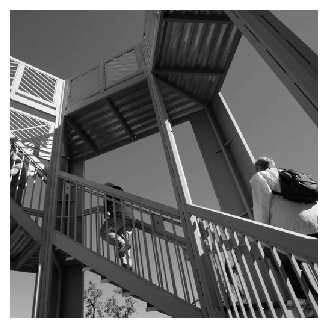

In [11]:
ascent = misc.ascent()
plt.imshow(ascent, cmap='gray')
plt.axis('off')
plt.show()

รูปที่ 4.3 ภาพบันไดจากไลบรารี <code>scipy.misc</code>

ตรวจจับขอบแนวตั้งโดยสังวัตนาการกับเคอร์เนล $h$ การกำหนด <code>mode='same'</code> จะได้เอาต์พุตเป็นเมทริกซ์ขนาดเท่ากับอินพุต 
แสดงภาพเอาต์พุตได้ดังรูปที่ 4.4

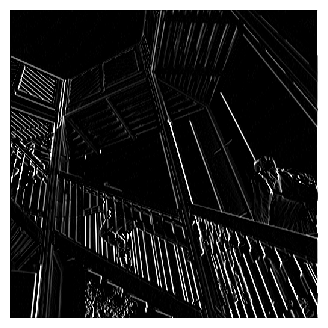

In [12]:
ascent_vertedge = signal.convolve2d(ascent,h,mode='same')
plt.imshow(ascent_vertedge, cmap='gray',vmin=0,vmax=255)
plt.axis('off')
plt.show()

รูปที่ 4.4 ผลจากการตรวจจับขอบของภาพบันไดในรูปที่ 4.3

### 4.1.1 การเสริมเต็มเมทริกซ์อินพุต

เราสามารถกำหนดตัวเลือกบางตัวในการดำเนินการสังวัตนาการเพื่อได้เอาต์พุตที่แตกต่างออกไป 
ตัวเลือกแรกที่ได้กล่าวถึงแล้วคือ <code>mode</code> ทำหน้าที่กำหนดการเสริมเต็มที่บริเวณขอบของเมทริกซ์อินพุต 
กรณีไม่มีการเสริมเต็มคือเลือก <code>mode='valid'</code> (ตัวอย่างดังในรูปที่ 4.1) เมทริกซ์อินพุตขนาด $n \times n$ 
เมื่อสังวัตนาการกับเคอร์เนลขนาด $f \times f$ จะได้เอาต์พุตเป็นเมทริกซ์ขนาด $(n-f+1) \times (n-f+1)$ 
ข้อเสียแรกคือในทุกครั้งที่มีการทำสังวัตนาการ เอาต์พุตจะมีขนาดเล็กลงกว่าเดิม ดังนั้นหากโมเดลมีชั้นสังวัตนาการจำนวนมาก 
ภาพจะถูกลดขนาดลงจนอาจมีขนาดเล็กเกินไป ข้อเสียที่สองคือพิกเซลที่อยู่บริเวณขอบจะถูกใช้ประมวลผลน้อยกว่าส่วนกลางภาพ 
ทำให้ข้อมูลบริเวณขอบภาพอาจถูกละทิ้งไป

ทางแก้คือกำหนด <code>mode = 'same'</code> มีผลให้เอาต์พุตจากการสังวัตนาการมีขนาดเท่ากับอินพุต 
หลักการคือเสริมบริเวณขอบทั้งสี่ด้านของเมทริกซ์อินพุตด้วยสมาชิกค่าคงที่ (นิยมใช้ค่าศูนย์) จากตัวอย่างในรูปที่ 
4.1 หากเสริมเต็มเมทริกซ์อินพุตเป็นขนาด $8 \times 8$ ด้วยขยายขอบออกไปทั้งสี่ด้าน จะได้เมทริกซ์เอาต์พุตขนาด 
$6 \times 6$ เท่ากับขนาดอินพุตก่อนการเสริมเต็ม ในกรณีทั่วไปเมื่อเลือกจำนวนพิกเซลเสริมเต็มในแต่ละด้านของอินพุตเท่ากับ $p$ 
จะทำให้ขนาดเมทริกซ์อินพุตขยายความกว้างและยาวเป็น $(n+2p) \times (n+2p)$ และขนาดเมทริกซ์เอาต์พุตเท่ากับ 
$(n+2p-f+1) \times $ $(n+2p-f+1)$
ดังนั้นเราสามารถหาค่าของ $p$ ที่ทำให้เอาต์พุตมีขนาดเท่ากับอินพุตเดิมคือ $n \times n$ ได้คือ $p = (f-1)/2$ 
ปกตินิยมเลือกขนาดของเคอร์เนล $f$ เป็นเลขคี่ ทำให้ค่าเสริมเต็ม $p$ เป็นเลขจำนวนเต็ม 
ซึ่งในไลบรารีทั่วไปที่ใช้งานง่ายเช่น <code>scipy</code> หรือ TF เมื่อกำหนด <code>mode='same'</code>
จะคำนวณค่า $p$ และเสริมเต็มให้โดยอัตโนมัติ

### 4.1.2 การกำหนดช่วงก้าว

อีกตัวเลือกหนึ่งที่สามารถเลือกกำหนดได้ในการดำเนินการสังวัตนาการระหว่าง เมทริกซ์อินพุตกับเคอร์เนลเรียกว่า <em>ช่วงก้าว (stride)</em> 
ซึ่งเป็นตัวกำหนดระยะ (จำนวนพิกเซล) ในการเลื่อนเคอร์เนลแต่ละครั้งทางแนวนอนและแนวตั้ง จากตัวอย่างในรูปที่ 4.1 
หากกำหนดช่วงก้าวเป็น $2$ ทั้งแนวนอนและแนวตั้ง เคอร์เนลจะถูกกวาดในลักษณะก้าวข้ามหนึ่งพิกเซล 
ผลคือเมทริกซ์เอาต์พุตจะมีขนาด $4 \times 4$ โดยตัดแถว $2,4$ และคอลัมน์ $2,4$ ของเมทริกซ์เอาต์พุตในรูปออกไป 

ในกรณีทั่วไป สำหรับเมทริกซ์อินพุตขนาด $n \times n$ และมีการเสริมเต็ม $p$ เคอร์เนลขนาด $f \times f$
เมื่อเลือกช่วงก้าว $s$ 
ทั้งแนวนอนและแนวตั้ง จะได้เอาต์พุตมีขนาด $m \times m$ โดย $m = \lfloor \frac{n+2p-f}{s} + 1 \rfloor$ 
ทั้งนี้ฟังก์ชันพื้นหรือ $\lfloor x \rfloor$ แทนเลขจำนวนเต็มมากที่สุดที่ไม่มากไปกว่า $x$ 
    
### 4.1.3 การสังวัตนาการ 3 มิติ

เราสามารถขยายการดำเนินการสังวัตนาการใน 2 มิติไปยังมิติที่สูงขึ้น ตัวอย่างในรูปที่ 4.5 เมื่ออินพุตเป็นภาพสีแทนด้วยองค์ประกอบสีแดง
เขียว น้ำเงิน ดังนั้นข้อมูลภาพจะเป็นเทนเซอร์อินพุตขนาด $n_h \times n_w \times n_c$ 
โดย $n_h, n_w, n_c$ แทนจำนวนพิกเซลด้านความสูง ความกว้าง และจำนวนช่อง (channel) ตามลำดับ 
(บางที่ใช้คำว่า "ความลึก" (depth) แทนช่อง แต่อาจทำให้สับสนกับความลึกของโครงข่ายประสาทเทียม) ส่วนเคอร์เนลเป็นเทนเซอร์ขนาด 
$f \times f \times n_c$ โดย $f$ คือขนาดของตัวกรอง (filter) ซึ่งต่อไปในหนังสือนี้จะเรียกว่าเคอร์เนล 
และ $n_c$ คือจำนวนช่องที่จะต้องเท่ากับจำนวนช่องของอินพุต 
กรณีไม่มีการเสริมเต็ม เอาต์พุตจะเป็นเมทริกซ์ขนาด $(n_h-f+1) \times (n_w-f+1)$ จากตัวอย่างด้านบนของรูปที่ 4.5 
แสดงขนาดเทนเซอร์อินพุต เคอร์เนล และเอาต์พุตเท่ากับ $6 \times 6 \times 3$, $3 \times 3 \times 3$ และ 
$4 \times 4 \times 1$ ตามลำดับ โดยแต่ละสมาชิกของเอาต์พุตคำนวณได้จากการคูณแต่ละสมาชิกของอินพุตกับเคอร์เนล 
ณ ตำแหน่งนั้น (รวมการดำเนินการคูณ 27 ครั้ง) แล้วรวมค่าเข้าด้วยกัน โดยวิธีการนี้เพิ่มความยืดหยุ่นในการประมวลผลภาพมากขึ้น 
เช่นตรวจจับขอบเฉพาะองค์ประกอบสีแดงของภาพ เป็นต้น

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1DzyiySSqnMLIPtlrRil3LKBZBT5of55S" width=550 />
</p>
<div align="center">รูปที่ 4.5 ตัวอย่างการสังวัตนาการ 3 มิติ</div>

จากตัวอย่างด้านบนของรูปที่ 4.5 สามารถขยายเป็นกรณีใช้เคอร์เนลหลายชุด ดังเช่นภาพด้านล่างแสดงการใช้เคอร์เนล 2 ชุด 
ทำให้ได้เอาต์พุตจากการสังวัตนาการเป็นเทนเซอร์ขนาด $4 \times 4 \times 2$ 
สำหรับกรณีทั่วไปขนาดของเทนเซอร์เอาต์พุตจะเท่ากับ $(n_h-f+1) \times (n_w-f+1) \times n_f$ 
โดย $n_f$ คือจำนวนชุดของเคอร์เนล หากมีการกำหนดค่าการเสริมเต็ม $p$ และช่วงก้าว $s$ 
จะได้เอาต์พุตมีขนาด $\lfloor \frac{n_h+2p-f}{s} + 1 \rfloor \times \lfloor \frac{n_w+2p-f}{s} + 1 \rfloor \times n_f$ 

## 4.2 ชั้นสังวัตนาการในโครงข่ายประสาทเทียม

เมื่อเข้าใจหลักการของการสังวัตนาการใน 3 มิติแล้วเราพร้อมที่จะศึกษาการสร้างชั้นสังวัตนาการสำหรับโครงข่ายประสาทเทียมดังแสดงในรูปที่ 4.6 
โดยสมมุติว่าเป็นชั้นที่ี $l$ ดังนั้นจากสัญกรณ์เดิมที่ใช้ อินพุตก็คือเอาต์พุตจากชั้นก่อนหน้านี้ $a^{[l-1]}$ และเอาต์พุตของชั้นนี้คือ $a^{[l]}$ 
เคอร์เนลที่ใช้ในรูปที่ 4.6 เป็นขนาด $3 \times 3 \times 3$ จำนวน 10 ชุด  

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1100bPkbNlInYZadIsGswYq5cExazhkME" width=750 />
</p>
<div align="center">รูปที่ 4.6 ชั้นสังวัตนาการใน CNN</div>

วัตถุประสงค์หลักของชั้นสังวัตนาการคือเพื่อปรับปรุงความสามารถในการจำแนกภาพโดยอาศัยข้อมูลเชิงพื้นที่ 
ส่วนของค่าแต่ละสมาชิกในเคอร์เนลจึงไม่ถูกกำหนดตายตัว 
แต่เป็นพารามิเตอร์ $W^{[l]}$ ที่สามารถเรียนรู้ได้จากการฝึก ดังนั้นส่วนเอาต์พุตเดิมในรูปที่ 4.5 คือ $W^{[l]}a^{[l-1]}$ 
หลังจากนั้นยังเพิ่มค่าเอนเอียง $b^{[l]}$ ทำให้ค่าเอาต์พุตส่วนเชิงเส้นเขียนได้เป็น

$$
z^{[l]} = W^{[l]}a^{[l-1]}+b^{[l]} \tag{4.2}
$$

และเอาต์พุตของชั้นคือ

$$
a^{[l]} = g(z^{[l]}) \tag{4.3}
$$

โดย $g()$ คือฟังก์ชันกระตุ้น นิยมใช้ ReLU() ดังในรูปที่ 4.2 สัญกรณ์ที่ใช้สำหรับชั้นสังวัตนาการ $l$ สามารถสรุปได้ดังนี้

-- ขนาดของเคอร์เนล : $f^{[l]}$
    
-- ขนาดของการเสริมเต็ม : $p^{[l]}$
    
-- ขนาดช่วงก้าว : $s^{[l]}$
    
-- จำนวนชุดของเคอร์เนล : $n_c^{[l]}$
    
-- ขนาดของเคอร์เนลแต่ละชุด : $f^{[l]} \times f^{[l]} \times n_c^{[l-1]}$
    
-- เทนเซอร์ค่าน้ำหนัก $W^{[l]}$ : $f^{[l]} \times f^{[l]} \times n_c^{[l-1]}$
    
-- ค่าเอนเอียง $b^{[l]}$ : $n_c^{[l]}$
    
-- ขนาดของอินพุต (คือเอาต์พุตชั้นก่อนหน้า $a^{[l-1]}$) : $n_h^{[l-1]} \times n_w^{[l-1]} \times n_c^{[l-1]}$
    
-- ขนาดของเอาต์พุต $a^{[l]}$ : $n_h^{[l-1]} \times n_w^{[l-1]} \times n_c^{[l-1]}$ โดยมีความสูงและความกว้าง $n_h^{[l]} = \lfloor \frac{n_h^{[l-1]}+2p^{l}-f^{[l]}}{s^{[l]}}+1 \rfloor, n_w^{[l]} = \lfloor \frac{n_w^{[l-1]}+2p^{l}-f^{[l]}}{s^{[l]}}+1 \rfloor$

-- ขนาดของเอาต์พุตในหนึ่งกลุ่มข้อมูล $A^{[l]}$ : $m \times n_h^{[l-1]} \times n_w^{[l-1]} \times n_c^{[l-1]}$ 
    
```{admonition} หมายเหตุ :
ลำดับของมิติในเทนเซอร์อาจแตกต่างกันตามไลบรารีที่ใช้ เช่นจำนวนช่องอาจถูกจัดไว้เป็นมิติแรก
```

### 4.2.1 ชั้นพูลลิง

นอกจากชั้นสังวัตนาการแล้ว ชั้นที่มักใช้ร่วมกันในการสร้าง CNN คือ <em>ชั้นพูลลิง (pooling layer)</em> 
ทำให้สามารถลดขนาดโมเดลลงเพื่อเพิ่มความเร็วในการคำนวณ รูปที่ 4.7 แสดงตัวอย่าง <em>ชั้นพูลลิงแบบใช้ค่ามากสุด 
(max pooling)</em> สมมุติว่าข้อมูลที่อินพุตของชั้นเป็นเมทริกซ์ขนาด $4 \times 4$ ไฮเปอร์พารามิเตอร์ของชั้นคือ 
ใช้เคอร์เนลขนาด $2 \times 2$ (f = 2) และช่วงก้าว s = 2 เมื่อนำเคอร์เนลมาซ้อนทับบนอินพุตในตำแหน่งบนซ้าย 
เลือกพิกเซลที่มีขนาดมากสุดคือ 8 เป็นเอาต์พุตของพูลลิงตำแหน่งบนซ้าย 
ต่อมาเลื่อนเคอร์เนลตามจำนวนช่วงก้าวเป็นเมทริกซ์ด้านบนขวาขนาด $2 \times 2$ เลือกค่ามากสุดคือ 2 
ทำเช่นนี้ไปจนครอบคลุมทั้งเมทริกซ์อินพุต จะเห็นว่าเมทริกซ์เอาต์พุตมีขนาดลดลงเป็น $2 \times 2$ 
โดยสูตรการคำนวณขนาดของเอาต์พุตชั้นสังวัตนาการสามารถนำมาใช้กับชั้นพูลลิงได้ (แต่ไม่นิยมใช้การเสริมเต็ม $p$ กับชั้นพูลลิง)

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1TzdZQDViRmKlHyDvITepdyqHVTq_X4cb" width=550 />
</p>
<div align="center">รูปที่ 4.7 การพูลลิงแบบใช้ค่ามากสุด </div>


หลักการของการพูลลิงแบบค่ามากสุดคือเลือกเฉพาะพิกเซลที่เป็นลักษณะเด่นในข้อมูลอินพุต ตัวอย่างเช่นภาพหลังจากการตรวจจับขอบ 
พิกเซลที่มีค่าสูงจะเป็นส่วนขอบขององค์ประกอบในภาพ สังเกตว่าชั้นพูลลิงจะมีเพียงไฮเปอร์พารามิเตอร์ที่ผู้ใช้กำหนดล่วงหน้าเท่านั้น 
ไม่มีพารามิเตอร์ที่ถูกปรับค่าจากการเรียนรู้ใดๆ เอาต์พุตแต่ละสมาชิกขึ้นอยู่กับการเลือกค่ามากสุดของอินพุตในตำแหน่งเคอร์เนลเท่านั้น

ชั้นพูลลิงอาจเลือกการดำเนินการเป็นแบบอื่นได้ เช่นใช้ค่าเฉลี่ยแทนค่าสูงสุด (รูปที่ 4.8) อย่างไรก็ตามในการใช้งานด้านการเรียนรู้เชิงลึก 
นิยมใช้ชั้นพุลลิงแบบค่ามากสุด

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1tJ_xXrXKyZSwlBo6laYnQuvuwK8bCrcF" width=550 />
</p>
<div align="center">รูปที่ 4.8 การพูลลิงแบบใช้ค่าเฉลี่ย</div>

รูปที่ 4.7 และ 4.8 แสดงการพูลลิงสำหรับอินพุตที่เป็น 2 มิติ ในกรณีที่อินพุตเป็นเทนเซอร์ที่มีจำนวนช่องเป็นมิติที่สาม 
เอาต์พุตที่ได้จากชั้นพูลลิงจะมีจำนวนช่องเท่ากับอินพุต โดยทำพูลลิงสำหรับแต่ละช่องเป็นอิสระต่อกัน

### 4.2.2 ตัวอย่างโมเดล CNN 

โครงสร้างของโมเดล CNN ที่ใช้กันโดยทั่วไปจะใช้ชั้นสังวัตนาการตามด้วยชั้นพูลลิงเป็นส่วนรับอินพุต โดยมีจำนวนคู่ตามผู้ใช้ต้องการ ในการนับชั้นของโมเดลอาจมีความแตกต่างกันอยู่บ้าง
คือมีการนับชั้นสังวัตนาการและชั้นพูลลิงแยกจากกัน หรือว่านับ 1 คู่เป็นชั้นเดียวก็ได้ รูปที่ 4.9 แสดงการใช้ชั้นสังวัตนาการและชั้นพูลลิง 2 คู่เป็นภาครับอินพุต 
สมมุติว่าภาพอินพุตเป็นภาพสี RGB ขนาด $32 \times 32 \times 3$ ชั้นสังวัตนาการแรกใช้เคอร์เนลขนาด $5 \times 5 \times 3$ จำนวน 6 ชุด 
ช่วงก้าว $s = 1$ กำหนด <code>padding='valid'</code> จะได้เอาต์พุตเป็นเทนเซอร์ขนาด $28 \times 28 \times 6$ ผ่านให้กับชั้นพูลลิง $f=2, s=2$ 
ได้เอาต์พุตเป็นเทนเซอร์ขนาด $14 \times 14 \times 6$ ชั้นสังวัตนาการที่สองใช้เคอร์เนลขนาด $5 \times 5 \times 3$ จำนวน 16 ชุด 
ช่วงก้าว $s = 1$ กำหนด <code>padding='valid'</code> จะได้เอาต์พุตเป็นเทนเซอร์ขนาด $10 \times 10 \times 16$ ผ่านให้กับชั้นพูลลิง $f=2, s=2$ 
ได้เทนเซอร์ $5 \times 5 \times 16$ เราสามารถเพิ่มคู่ของชั้นสังวัตนาการและชั้นพูลลิงได้อีก แต่หากไม่ต้องการแล้วจะปิดส่วนท้ายของโมเดลด้วยชั้นที่เชื่อมต่อเต็ม 
มีจำนวนชั้นตามที่ต้องการ โดยก่อนที่จะเข้าสู่ชั้นเชื่อมต่อเต็มชั้นแรกจะต้องแผ่ข้อมูลออก (flatten) เป็นหนึ่งมิติ จากตัวอย่างนี้เทนเซอร์ขนาด $5 \times 5 \times 16$ 
ถูกแผ่เป็นเวกเตอร์หนึ่งมิติที่มีจำนวนสมาชิกเท่ากับ 400 หลังจากนั้นโครงสร้างโมเดลจะเหมือนกับ DNN ที่ได้กล่าวถึงในบทที่ 2 โดยในตัวอย่างรูปที่ 4.9 
ชั้นเอาต์พุตเป็นการจำแนกข้อมูลภาพออกเป็น $k$ ประเภท

<div style=".noindent"><b>ตัวอย่าง 4.2</b></div>

ในตัวอย่างนี้จะทดลองสร้างโมเดล CNN โดยไลบรารี TF เพื่อจำแนกภาพแมวกับสุนัข สามารถใช้ข้อมูลเดิมที่ดาวน์โหลดในตัวอย่าง 2.5 บทที่ 2 
เพื่อความสะดวกและลดเวลาการฝึกลงจะดาวน์โหลดเซตย่อยโดยรันเซลล์ด้านล่างนี้ (ข้อมูลจากกูเกิลเพื่อการศึกษา)

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1raIMcE1pzuEBi77jISNycXwdG3i33iqe" width=650 />
</p>
<div align="center">รูปที่ 4.9 ตัวอย่างโมเดล CNN สำหรับจำแนกภาพ</div>

```{admonition} หมายเหตุ :
ผู้อ่านต้องติดตั้งโปรแกรม wget บนเครื่องคอมพิวเตอร์เสียก่อน
```

In [13]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2022-12-02 09:20:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4001:80a::2010, 2404:6800:4001:809::2010, 2404:6800:4001:80f::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4001:80a::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  14.5MB/s    in 4.5s    

2022-12-02 09:20:07 (14.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



เรียกไลบรารีของระบบปฏิบัติการเพื่อเข้าถึงและแตกไฟล์

In [14]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

โดยไฟล์จะถูกเก็บในไดเรคทอรีฐาน <code>/tmp/cats_and_dogs_filtered</code> 
แยกเป็นไดเรคทอรีย่อย <code>train</code> และ <code>validation</code> 
และภายในประกอบด้วยไดเรคทอรีย่อย <code>cats</code> และ <code>dogs</code>
เพื่อความสะดวกในการใช้งาน <code>ImageGenerator</code> นิยามเส้นทางไปยังข้อมูลฝึกและตรวจสอบดังนี้

In [15]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


ดูชื่อไฟล์บางไฟล์ในแต่ละประเภทของสัตว์เลี้ยง และจำนวนภาพทั้งหมดที่ใช้ในการฝึกและตรวจสอบ

In [16]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.307.jpg', 'cat.769.jpg', 'cat.763.jpg', 'cat.252.jpg', 'cat.722.jpg', 'cat.326.jpg', 'cat.731.jpg', 'cat.136.jpg', 'cat.606.jpg', 'cat.258.jpg']
['dog.250.jpg', 'dog.170.jpg', 'dog.488.jpg', 'dog.136.jpg', 'dog.274.jpg', 'dog.513.jpg', 'dog.717.jpg', 'dog.142.jpg', 'dog.503.jpg', 'dog.911.jpg']


In [17]:
print('จำนวนภาพแมวสำหรับฝึก :', len(os.listdir(      train_cats_dir ) ))
print('จำนวนภาพสุนัขสำหรับฝึก :', len(os.listdir(      train_dogs_dir ) ))

print('จำนวนภาพแมวสำหรับตรวจสอบ :', len(os.listdir( validation_cats_dir ) ))
print('จำนวนภาพสุนัขสำหรับตรวจสอบ :', len(os.listdir( validation_dogs_dir ) ))

จำนวนภาพแมวสำหรับฝึก : 1000
จำนวนภาพสุนัขสำหรับฝึก : 1000
จำนวนภาพแมวสำหรับตรวจสอบ : 500
จำนวนภาพสุนัขสำหรับตรวจสอบ : 500


ทดลองแสดงบางภาพในรูปแบบ $4 \times 4$ สำหรับแต่ละประเภท เริ่มจากการเรียกไลบรารี กำหนดค่าจำนวนแถว คอลัมน์ และตัวชี้

In [18]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4
pic_index = 0 


เอาต์พุตในรูปที่ 4.10 จะเปลี่ยนไปตามลำดับในชุดข้อมูลสำหรับทุกครั้งของการรันเซลล์ด้านล่างนี้ โดยสองแถวบนเป็นภาพแมวและสองแถวล่างเป็นสุนัข 
สังเกตว่าข้อมูลเป็นภาพสีที่มีขนาดแตกต่างกัน บางภาพมีสัตว์เลี้ยงมากกว่าหนึ่งตัว หรือมีมนุษย์อยู่ด้วย 

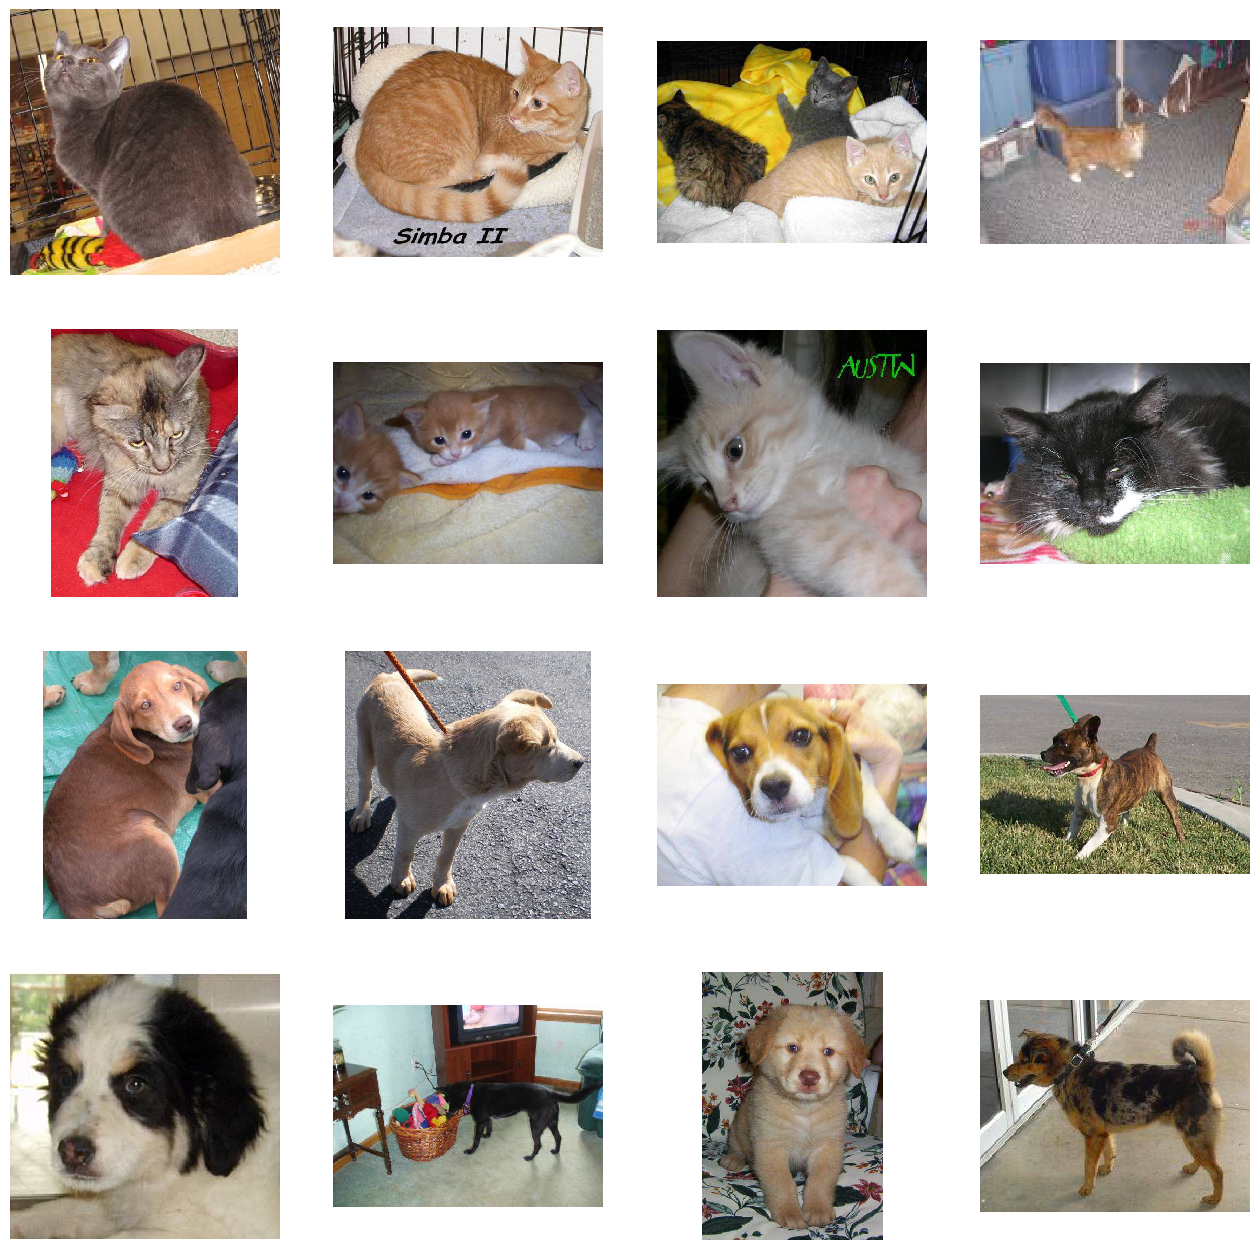

In [19]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

<div align="center">รูปที่ 4.10 ตัวอย่างภาพแมวและสุนัขที่ใช้ในการฝึก</div>

นำเข้าไลบรารีที่ต้องการ และนิยามให้ใช้งานง่ายขึ้น ชั้นที่นำเข้าใหม่ในบทนี้คือ <code>Conv2D()</code> 
สำหรับการสังวัตนาการ และ <code>MaxPooling2D()</code> สำหรับการทำพูลลิง 
ที่เหลือคือที่เราเคยใช้งานแล้วก่อนหน้านี้

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten 
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

สร้างโมเดล CNN โดยมีชั้นส่วนบนเป็นคู่ของ <code>Conv2D()</code> และ <code>MaxPooling2D()</code> 
สำหรับอาร์กิวเมนต์ทั้งหมดสามารถอ้างอิงจากหน้าช่วยเหลือของ TF 
ตัวที่สำคัญคืออาร์กิวเมนต์สองตัวแรกแทนจำนวนและขนาดของเคอร์เนลตามลำดับ เช่น <code>Conv2D()</code> 
ชั้นแรกใช้เคอร์เนล 16 ตัว ขนาด $3 \times 3$ 
(กำหนดโดย (3,3) หรือใช้ 3 ตัวเดียวก็ได้) ฟังก์ชันกระตุ้นที่เอาต์พุตเป็นแบบ ReLU 
สำหรับชั้นแรกอาร์กิวเมนต์ที่จำเป็นต้องใส่คือ <code>input_shape</code> ซึ่งจะต้องสอดคล้องกับความกว้าง ยาว และจำนวนช่องของภาพที่ใช้เป็นอินพุต 
ในที่นี้เรากำหนดขนาดภาพเท่ากับ $150 \times 150$ และเป็นภาพสีที่แทนด้วย 3 ช่อง (สีแดง เขียว น้ำเงิน) 
อาร์กิวเมนต์ที่ไม่ได้ระบุจะถูกแทนด้วยค่าโดยปริยาย 
เช่น <code>stride = (1,1), padding='valid'</code>

สำหรับชั้น <code>MaxPooling2D(2,2)</code> คือขนาดของเคอร์เนลเท่ากับ $2 \times 2$ และช่วงก้าวเท่ากับ 2 ซึ่งจะให้ผลเหมือนที่แสดงในรูปที่ 4.7

หลังจากผ่านชั้นสังวัตนาการและพูลลิงตามจำนวนคู่ที่ต้องการแล้ว 
จะต้องแผ่ข้อมูลออกเป็นเวกเตอร์หนึ่งมิติโดยชั้น <code>Flatten()</code> ก่อนจะเข้าสู่ชั้น <code>Dense()</code> 
ซึ่งเหมือนกับโมเดล DNN ที่ศึกษาก่อนหน้านี้ เอาต์พุตชั้นสุดท้ายมีเซลล์เพียงหนึ่งตัวและใช้ฟังก์ชันกระตุ้นแบบซิกมอยต์ เนื่องจากเป็นปัญหาการจำแนกทวิภาค 
โดยค่า 0 แทนภาพแมวและ 1 แทนภาพสุนัข
สังเกตว่าเราต้องกำหนดขนาดของเทนเซอร์อินพุตเฉพาะชั้นแรกของโมเดลเท่านั้น หลังจากนั้นขนาดของเอาต์พุตและอินพุตในชั้นต่อๆ 
ไปจนถึงเอาต์พุตขั้นสุดท้ายจะถูกกำหนดโดยไฮเปอร์พารามิเตอร์ที่ผู้ใช้เลือก 

In [21]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    Flatten(), 
    Dense(512, activation='relu'), 
    Dense(1, activation='sigmoid')  
])

ดูข้อมูลสรุปสำหรับโมเดลได้โดยคำสั่ง <code>model.summary()</code> ที่จะแสดงขนาดของเทนเซอร์ในชั้นหลังจากอินพุตสอดคล้องกับที่ระบุในหัวข้อ 4.2 
รวมถึงจำนวนพารามิเตอร์ในแต่ละชั้น เนื่องจากค่าโดยปริยายของ <code>Conv2D()</code> จะไม่มีการเสริมเต็ม ดังนั้นความกว้างและความยาวของภาพจะลดลง
2 พิกเซลเมื่อใช้เคอร์เนลขนาด $3 \times 3$ และจำนวนช่องเปลี่ยนไปตามจำนวนชุดของเคอร์เนลที่ใช้ในชั้นนั้น สำหรับชั้น 
<code>MaxPooling2D(2,2)</code> 
จะลดความกว้างและความยาวภาพลงครึ่งหนึ่ง 

สังเกตจำนวนพารามิเตอร์ของชั้น <code>Conv2D()</code> ที่มีค่าน้อยกว่าชั้น <code>Dense()</code> อย่างชัดเจน 
ส่วนชั้น <code>MaxPooling2D()</code> 
ไม่มีพารามิเตอร์เรียนรู้ การลดจำนวนของพารามิเตอร์การเรียนรู้เป็นข้อได้เปรียบสำคัญอีกประการหนึ่งของโมเดล CNN 

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

```
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_4 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
```
                 
```
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               9470464   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
=================================================================
Total params: 9,494,561
Trainable params: 9,494,561
Non-trainable params: 0
_________________________
```

ก่อนการฝึกจะต้องใช้คำสั่ง <code>model.compile()</code> เลือกตัวหาค่าเหมาะที่สุดแบบ <code>RMSprop</code> อัตราการเรียนรู้ 0.001 
และฟังก์ชันสูญเสียแบบ <code>binary_crossentropy</code> 

In [25]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

เช่นเดียวกับในตัวอย่าง 2.5 ในกรณีที่ข้อมูลภาพถูกจัดเก็บในไดเรคทอรีย่อย เป็นการเหมาะสมที่จะใช้ <code>ImageDataGenerator</code>
ที่มีให้ในไลบรารี TF 
เพื่อจัดการโหลดข้อมูลและประมวลผลเบื้องต้น โดยค่าของแต่ละพิกเซลเดิมในช่วง [0,255] จะถูกปรับมาตราส่วนให้อยู่ในช่วง [0,1] 
จากนั้นภาพอินพุตจะถูกปรับขนาดให้สอดคล้องกับที่กำหนดไว้ในอาร์กิวเมนต์ <code>input_shape</code>
คือ $150 \times 150$ กำหนดขนาดกลุ่มข้อมูลเท่ากับ 20 
ดำเนินการเหมือนกันสำหรับข้อมูลฝึกและตรวจสอบ

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir,batch_size=20,class_mode='binary',target_size=(150, 150))     
validation_generator =  test_datagen.flow_from_directory(validation_dir,batch_size=20,class_mode  = 'binary',target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


ฝึกโมเดลจำนวน 15 รอบ ใช้เวลานานมากน้อยขึ้นกับคอมพิวเตอร์ที่ใช้ หากตั้งค่า <code>verbose</code> ไม่เป็นศูนย์ 
จะเห็นเอาต์พุตจากการฝึกในแต่ละรอบ ซึ่งจะถูกเก็บในดิกชันนารี <code>history</code> ด้วย

In [26]:
history = model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=100,epochs=15,validation_steps=50,verbose=2)

Epoch 1/15
100/100 - 23s - loss: 0.7977 - accuracy: 0.5610 - val_loss: 0.6353 - val_accuracy: 0.6780 - 23s/epoch - 228ms/step
Epoch 2/15
100/100 - 24s - loss: 0.6383 - accuracy: 0.6640 - val_loss: 0.5767 - val_accuracy: 0.7020 - 24s/epoch - 241ms/step
Epoch 3/15
100/100 - 24s - loss: 0.5575 - accuracy: 0.7245 - val_loss: 0.5600 - val_accuracy: 0.7170 - 24s/epoch - 240ms/step
Epoch 4/15
100/100 - 23s - loss: 0.4744 - accuracy: 0.7765 - val_loss: 0.5872 - val_accuracy: 0.6900 - 23s/epoch - 234ms/step
Epoch 5/15
100/100 - 22s - loss: 0.3860 - accuracy: 0.8255 - val_loss: 0.7123 - val_accuracy: 0.6720 - 22s/epoch - 225ms/step
Epoch 6/15
100/100 - 22s - loss: 0.2957 - accuracy: 0.8690 - val_loss: 0.6745 - val_accuracy: 0.7080 - 22s/epoch - 222ms/step
Epoch 7/15
100/100 - 21s - loss: 0.2319 - accuracy: 0.9060 - val_loss: 0.9720 - val_accuracy: 0.6910 - 21s/epoch - 208ms/step
Epoch 8/15
100/100 - 20s - loss: 0.1648 - accuracy: 0.9375 - val_loss: 0.8605 - val_accuracy: 0.7190 - 20s/epoch - 202

```{admonition} ตัวอย่างเอาต์พุต
:class: tip
<div style="font-size: 12pt">
<br>Epoch 1/15
<br>100/100 - 21s - loss: 0.8485 - accuracy: 0.5630 - val_loss: 0.6613 - val_accuracy: 0.6050
<br>Epoch 2/15
<br>100/100 - 22s - loss: 0.6317 - accuracy: 0.6585 - val_loss: 0.5691 - val_accuracy: 0.6970
<br>Epoch 3/15
<br>100/100 - 20s - loss: 0.5566 - accuracy: 0.7175 - val_loss: 0.7435 - val_accuracy: 0.6280
<br>:
<br>:
<br>Epoch 14/15
<br>100/100 - 23s - loss: 0.0424 - accuracy: 0.9860 - val_loss: 1.7255 - val_accuracy: 0.7230
<br>Epoch 15/15
<br>100/100 - 22s - loss: 0.0373 - accuracy: 0.9930 - val_loss: 1.7547 - val_accuracy: 0.7130
</div>
```

พล็อตค่าความแม่นยำและค่าสูญเสียจากข้อมูลฝึกและตรวจสอบดังในรูปที่ 4.11 จากเอาต์พุตในแต่ละรอบการฝึกและกราฟ 
(ใช้ฟังก์ชัน <code>plot_acc_loss()</code> ที่นิยามไว้ในบทก่อนหน้านี้)
จะเห็นได้ว่าโมเดลมีการพิตเกิน โดยสังเกตได้จากความแม่นยำจากข้อมูลตรวจสอบน้อยกว่าที่ได้จากข้อมูลฝึกอย่างมีนัยสำคัญ 
ขณะที่หลังการฝึกไปได้ระยะหนึ่ง ค่าสูญเสียจากข้อมูลตรวจสอบมีแนวโน้มเพิ่มขึ้น

In [27]:
# use history.history in agrument 
def plot_acc_loss(history):
    acc=history['accuracy']
    val_acc=history['val_accuracy']
    loss=history['loss']
    val_loss=history['val_loss']
    epochs=range(len(acc)) # Get number of epochs
    acc_txt = str(round(acc[len(acc)-1]*100,2))
    val_acc_txt = str(round(val_acc[len(val_acc)-1]*100,2))
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epochs, acc,'r',epochs,val_acc,'b')
    ax1.set_title('Training and validation accuracy')
    ax1.legend(["Training acc = "+acc_txt+" %","Validation acc = "+val_acc_txt+" %"])
    loss_txt = str(round(loss[len(loss)-1],2))
    val_loss_txt = str(round(val_loss[len(val_loss)-1],2))
    ax2.plot(epochs, loss, 'r',epochs, val_loss, 'b')
    ax2.legend(["Training loss = "+loss_txt,"Validation loss = "+val_loss_txt])
    ax2.set_title('Training and validation loss');

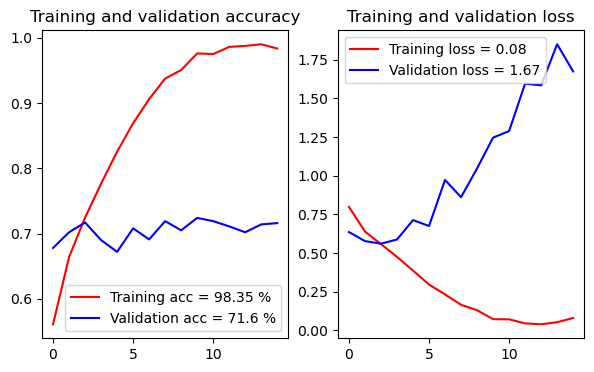

In [28]:
plot_acc_loss(history.history)

รูปที่ 4.11 กราฟความแม่นยำและค่าสูญเสียจากข้อมูลฝึกและตรวจสอบ 

เราสามารถแสดงมโนภาพจากเอาต์พุตในแต่ละชั้นสังวัตนาการและพูลลิงเพื่อทำความเข้าใจการเรียนรู้เชิงลึกโดยโมเดล CNN ได้ดังรูปที่ 4.12 
โดยรันโค้ดในเซลล์ด้านล่างนี้



In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)
x /= 255.0
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

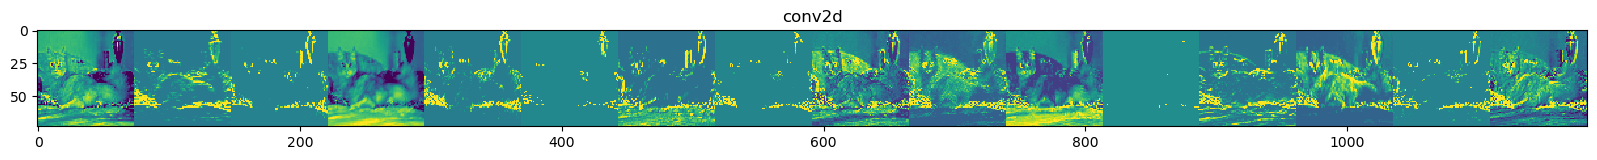

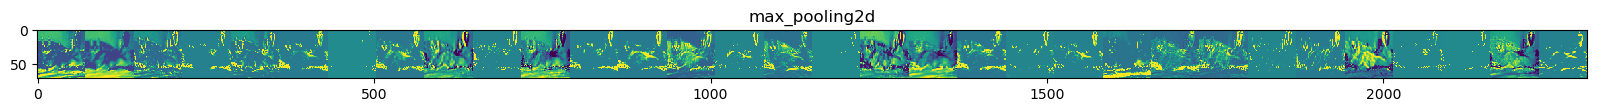

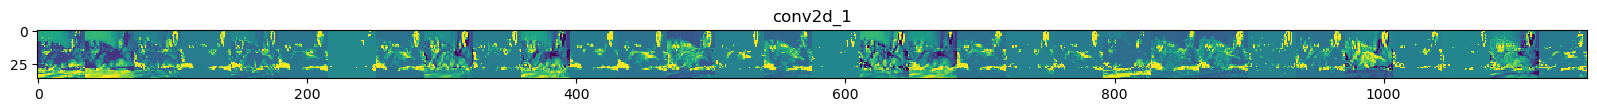

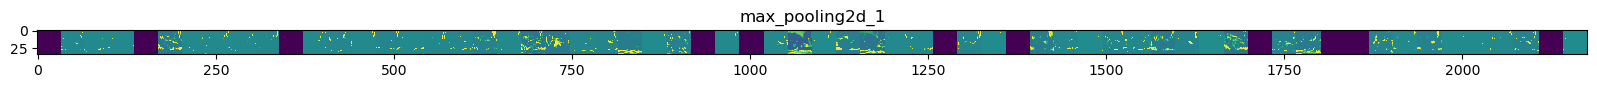

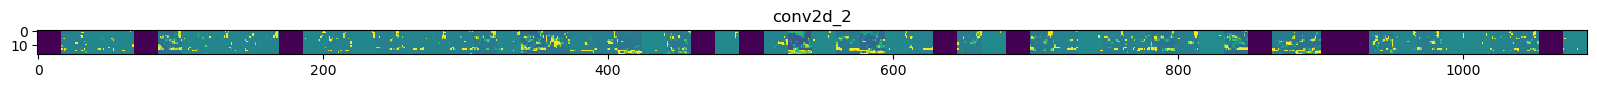

In [39]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps):  
    if len(feature_map.shape) == 4:    
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)        
        display_grid = np.zeros((size, size * n_features))    
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

<div align="center">รูปที่ 4.12 เอาต์พุตจากชั้นสังวัตนาการและพูลลิงในโมเดล CNN</div>

แม้ว่ามนุษย์อาจสื่อความหมายจากเอาต์พุตจากรูปที่ 4.12 ได้ไม่ดีนัก แต่พอสังเกตได้ถึงหลักการของการเรียนรู้เชิงลึกโดย CNN 
โดยภาพในชั้นล่างลงมาจะมีรายละเอียดของภาพน้อยลง แต่พยายามจับเฉพาะลักษณะเด่นของภาพที่โมเดลให้ความสนใจ เช่นส่วนขอบของตัวสัตว์  

ผู้อ่านสามารถทดสอบโมเดลกับภาพสัตว์เลี้ยงของท่านได้โดยใส่ภาพที่ไดเรคทอรีย่อย <code>/content/</code>
กำหนดตัวแปร <code>fn</code> ในโค้ดด้านล่างนี้ให้ตรงกับชื่อไฟล์
แล้วรันเซลล์ รูปที่ 4.13 แสดงผลการพยากรณ์บางภาพของแมวและสุนัขของผู้เขียน 

maam.jpeg is a dog


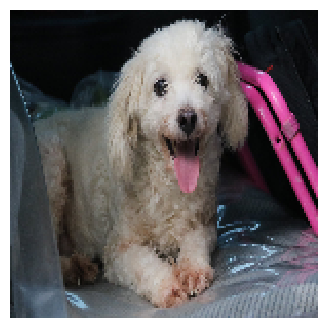

In [40]:
from keras.preprocessing import image
fn = "maam.jpeg"
# predicting images
path='content/' + fn
img=image.load_img(path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
if classes[0]>0:
    print(fn + " is a dog")
else:
    print(fn + " is a cat")

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1JSjpdvn2YM9yz-KSyIv1iJpeESBWm04v" width=650 />
</p>
<div align="center">รูปที่ 4.13 ผลการพยากรณ์ภาพสุนัขและแมวโดยโมเดล CNN ในตัวอย่าง 4.2</div>

<p />
<div style=".noindent"><b>ตัวอย่าง 4.3</b></div>

ในตัวอย่าง 3.8 เราใช้โมเดล DNN จำแนกเซตข้อมูล The Street View House Number (SVHN) จากเว็บไซต์ 
http://ufldl.stanford.edu/housenumbers/ ได้ความแม่นยำประมาณ 80% ในตัวอย่างนี้จะสร้างโมเดล CNN 
เพื่อเปรียบเทียบสมรรถนะการจำแนกภาพ 

นำเข้าไลบรารีทั้งหมดที่ใช้งาน


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler 
from tensorflow.keras.optimizers import Adam

โหลดข้อมูลและประมวลผลเบื้องต้นดังเช่นในตัวอย่าง 3.8

In [42]:
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')
train_images_rgb, train_labels = train['X'],train['y']
test_images_rgb, test_labels = test['X'],test['y']
train_images_rgb = np.moveaxis(train_images_rgb, 3,0) # permute axis so that number of samples come first
test_images_rgb = np.moveaxis(test_images_rgb, 3,0)
N = train_images_rgb.shape[0]
train_labels = np.where(train_labels==10,0,train_labels)
test_labels = np.where(test_labels==10,0,test_labels)
train_images = np.mean(train_images_rgb,axis=-1,keepdims=True)/255.
test_images = np.mean(test_images_rgb,axis=-1,keepdims=True)/255.

สร้าง คอมไพล์ และฝึกโมเดล DNN โดยโค้ดเดียวกับตัวอย่าง 3.8 เพื่อใช้สำหรับเปรียบเทียบ ตั้งชื่อว่า <code>model_dnn</code>

In [43]:
model_dnn = Sequential([
    Flatten(input_shape=(32,32,1)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')    
])


In [44]:
model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)              

```
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               131200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
=================================================================
Total params: 200,458
Trainable params: 199,434
Non-trainable params: 1,024
```

จะเห็นว่ามีพารามิเตอร์ทั้งหมด 200,458 ตัว

In [45]:
model_dnn.compile(optimizer=Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [46]:
def scheduler(epoch, lr):
    return lr * (1/(1+epoch))
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
early_stopping = EarlyStopping(patience=3, monitor='val_accuracy', mode='max')

In [47]:
history_dnn=model_dnn.fit(train_images, train_labels, epochs=30, batch_size=256, validation_split = 0.15,
                  callbacks=[lr_scheduler,early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
244/244 [==============================] - 3s 11ms/step - loss: 1.2712 - accuracy: 0.5944 - val_loss: 1.6708 - val_accuracy: 0.4389 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/30
244/244 [==============================] - 2s 10ms/step - loss: 0.7884 - accuracy: 0.7601 - val_loss: 1.1008 - val_accuracy: 0.6442 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00016666667458290854.
Epoch 3/30
244/244 [==============================] - 2s 9ms/step - loss: 0.6675 - accuracy: 0.8004 - val_loss: 0.8106 - val_accuracy: 0.7457 - lr: 1.6667e-04

Epoch 4: LearningRateScheduler setting learning rate to 4.166666985838674e-05.
Epoch 4/30
244/244 [==============================] - 3s 12ms/step - loss: 0.6219 - accuracy: 0.8140 - val_loss: 0.6677 - val_accuracy: 0.7993 - lr: 4.1667e-05

Epoch 5: LearningRateScheduler setting lear

```{admonition} ตัวอย่างเอาต์พุต
:class: tip
<div style="font-size: 12pt">
<br>Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
<br>Epoch 1/30
<br>244/244 [==============================] - 2s 5ms/step - loss: 1.2747 - accuracy: 0.5928 - val_loss: 1.8160 - val_accuracy: 0.4151
<br>Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
<br>Epoch 2/30
<br>244/244 [==============================] - 1s 4ms/step - loss: 0.7905 - accuracy: 0.7577 - val_loss: 1.0235 - val_accuracy: 0.6769
<br>:
<br>Epoch 13: LearningRateScheduler setting learning rate to 1.6059045786541117e-13.
<br>Epoch 13/30
<br>244/244 [==============================] - 1s 4ms/step - loss: 0.6038 - accuracy: 0.8177 - val_loss: 0.6511 - val_accuracy: 0.8026
</div>
```

พล็อตค่าความแม่นยำและค่าสูญเสียได้ดังในรูปที่ 4.14

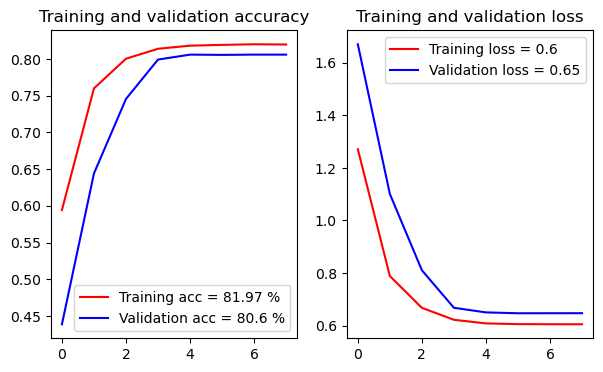

In [48]:
plot_acc_loss(history_dnn.history)

<div align="center">รูปที่ 4.14 ค่าความแม่นยำและค่าสูญเสียของโมเดล DNN</div>

สร้างโมเดล CNN ที่มีชั้นสังวัตนาการและพูลลิงจำนวน 2 ชุด ตามด้วยชั้น <code>BatchNormalization()</code> 
และ <code>Dropout()</code> เพื่อลดการฟิตเกิน 
ปิดด้วยชั้นเชื่อมต่อเต็มที่มีจำนวนเซลล์ 64, 64 และ 10 เมื่อตรวจสอบพารามิเตอร์ทั้งหมดพบว่าใช้เพียง 83,658 ตัว

In [49]:
model_cnn = Sequential([
    Conv2D(16, (3,3), activation='relu',input_shape=(32,32,1)),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),    
    BatchNormalization(),
    Dropout(0.5),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation = 'relu'),  
    Dense(10, activation = 'softmax')    
])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 6, 6, 32)         128       
 hNormalization)                                                 
                                                      

```
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 6, 6, 32)         128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 6, 6, 32)          0         
                                                                 
 batch_normalization_4 (Batc  (None, 6, 6, 32)         128       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                73792     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
=================================================================
Total params: 83,658
Trainable params: 83,530
Non-trainable params: 128
```

คอมไพล์และฝึกโมเดลโดยใช้อาร์กิวเมนต์เหมือนกับโมเดล DNN

In [50]:
model_cnn.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [51]:
history_cnn=model_cnn.fit(train_images, train_labels, epochs=30, batch_size=256, validation_split = 0.15,callbacks=[lr_scheduler,early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
244/244 [==============================] - 25s 103ms/step - loss: 1.3137 - accuracy: 0.5684 - val_loss: 1.7060 - val_accuracy: 0.6198 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/30
244/244 [==============================] - 23s 94ms/step - loss: 0.7069 - accuracy: 0.7840 - val_loss: 0.9715 - val_accuracy: 0.7907 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00016666667458290854.
Epoch 3/30
244/244 [==============================] - 22s 91ms/step - loss: 0.6260 - accuracy: 0.8105 - val_loss: 0.5398 - val_accuracy: 0.8528 - lr: 1.6667e-04

Epoch 4: LearningRateScheduler setting learning rate to 4.166666985838674e-05.
Epoch 4/30
244/244 [==============================] - 22s 91ms/step - loss: 0.6063 - accuracy: 0.8166 - val_loss: 0.5037 - val_accuracy: 0.8559 - lr: 4.1667e-05

Epoch 5: LearningRateScheduler settin

```{admonition} ตัวอย่างเอาต์พุต
:class: tip
<div style="font-size: 12pt">
<br>Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
<br>Epoch 1/30
<br>244/244 [==============================] - 25s 103ms/step - loss: 1.3137 - accuracy: 0.5684 - val_loss: 1.7060 - val_accuracy: 0.6198 - lr: 0.0010
<br>Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
<br>Epoch 2/30
<br>244/244 [==============================] - 23s 94ms/step - loss: 0.7069 - accuracy: 0.7840 - val_loss: 0.9715 - val_accuracy: 0.7907 - lr: 5.0000e-04
<br>:
<br>Epoch 8: LearningRateScheduler setting learning rate to 2.4801590114975625e-08.
<br>Epoch 8/30
<br>244/244 [==============================] - 21s 88ms/step - loss: 0.5973 - accuracy: 0.8193 - val_loss: 0.4969 - val_accuracy: 0.8555 - lr: 2.4802e-08
</div>
```

พล็อตค่าความแม่นยำและค่าสูญเสียได้ดังในรูปที่ 4.15 จะเห็นว่าได้ความแม่นยำในการจำแนกสูงกว่าโมเดล DNN

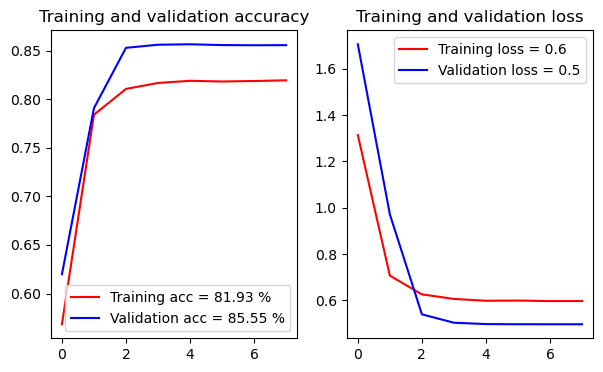

In [52]:
plot_acc_loss(history_cnn.history)

รูปที่ 4.15 ค่าความแม่นยำและค่าสูญเสียของโมเดล CNN

ขั้นสุดท้ายคือเปรียบเทียบผลการพยากรณ์ระหว่างโมเดล DNN และ CNN รูปที่ 4.16 แสดงการสุ่มภาพจำนวน 5 ภาพจากชุดข้อมูลทดสอบ 
และดูผลการพยากรณ์จากโมเดลเปรียบเทียบกับเลเบลจริง กราฟแท่งทางด้านขวาแสดงค่าความน่าจะเป็นจากชั้นเอาต์พุตของโมเดล 
ซึ่งค่าสูงสุดคือตัวเลขที่โมเดลพยากรณ์ รันเซลล์ด้านล่างหลายครั้งเพื่อเปลี่ยนภาพ เปรียบเทียบความแม่นยำระหว่างสองโมเดล 
สังเกตภาพที่โมเดลพยากรณ์ไม่ถูกต้องว่ามีองค์ประกอบใดที่สร้างความสับสน

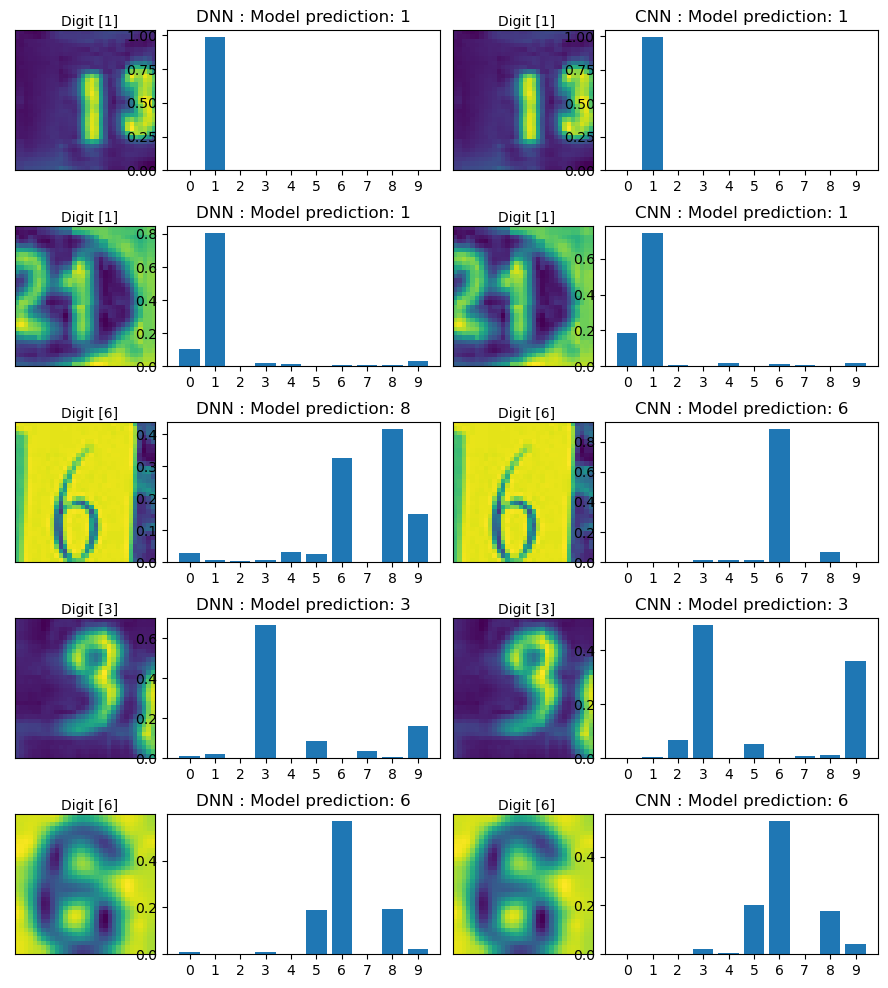

In [58]:
num_test_images = test_images.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]
DNN_predictions = model_dnn.predict(random_test_images) 
CNN_predictions = model_cnn.predict(random_test_images)
#do the plots
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)
for i, (prediction, image, label) in enumerate(zip(DNN_predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"DNN : Model prediction: {np.argmax(prediction)}")
for i, (prediction, image, label) in enumerate(zip(CNN_predictions, random_test_images, random_test_labels)):
    axes[i, 2].imshow(np.squeeze(image))
    axes[i, 2].get_xaxis().set_visible(False)
    axes[i, 2].get_yaxis().set_visible(False)
    axes[i, 2].text(10., -1.5, f'Digit {label}')
    axes[i, 3].bar(np.arange(len(prediction)), prediction)
    axes[i, 3].set_xticks(np.arange(len(prediction)))
    axes[i, 3].set_title(f"CNN : Model prediction: {np.argmax(prediction)}")    
plt.show()

<div align="center">รูปที่ 4.16 เปรียบเทียบผลการพยากรณ์ระหว่างโมเดล DNN และ CNN</div>

## 4.3 การแต่งเติมช้อมูลภาพ

จากตัวอย่าง 4.2 จะพบว่าโมเดลมีการฟิตเกินเนื่องจากการที่ข้อมูลภาพสำหรับการฝึกมีจำนวนไม่มาก 
การแก้ไขโดยตรงคือเพิ่มจำนวนข้อมูลการฝึก ในกรณีที่ไม่สามารถเพิ่มข้อมูลได้ สามารถใช้วิธีแต่งเติมภาพ 
(image augmentation) โดยหลักการคือใช้กรรมวิธีประมวลผลภาพกับภาพเดิมที่มีอยู่เพื่อให้ได้ข้อมูลฝึกเพิ่มขึ้น 
ตัวอย่างเช่นสมมุติภาพแมวทั้งหมดที่หาได้มีส่วนหูอยู่ในแนวตั้ง ซึ่งอาจเป็นลักษณะเด่นที่โมเดล CNN ใช้ตัดสินใจ 
แต่เมื่อทดสอบโมเดลด้วยภาพแมวที่ไต่ลงจากกิ่งไม้ลาดชัน หรือแมวในท่านอน หูของแมวเอียงทำมุมกับแกนหลักของภาพ ทำให้โมเดลจำแนกผิดพลาด 
ดังนั้นหากหมุนภาพเดิมเพื่อใช้ในกาฝึกอาจช่วยให้การจำแนกภาพแมวทำได้แม่นยำขึ้น การแต่งเติมภาพโดยทั่วไปทำได้
โดยการคัดเลือกเฉพาะบางส่วนของภาพ การพลิกในแนวตั้งและแนวนอน การหมุน การเฉือน การปรับแต่งสี 
หรือการดำเนินการอื่นที่ผู้พัฒนาเห็นว่าเป็นประโยชน์ต่อโจทย์ปัญหา รูปที่ 4.17 
แสดงตัวอย่างการแต่งเติมภาพแมวเพื่อเพิ่มความหลากหลายของข้อมูลฝึก

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1RPQuklHsnF3S-eq6QaB0SjeHPhyHNZ_w" width=550 />
</p>
<div align="center">รูปที่ 4.17 การแต่งเติมภาพโดยการกลับด้าน หมุนและเฉือน </div>

<div style=".noindent"><b>ตัวอย่าง 4.4</b></div>
 
สมมุติว่าเราต้องการแก้ปัญหาการฟิตเกินในตัวอย่าง 4.2 แต่ไม่สามารถหาภาพเพิ่มเติมสำหรับฝึกได้ จึงต้องการใช้วิธีการแต่งเติมภาพที่มีอยู่  
ซึ่งสามารถใช้คลาส <code>ImageDataGenerator</code> ช่วย ซึ่งมีข้อดีคือไม่จำเป็นต้องเปลืองทรัพยากรสำหรับเก็บข้อมูลภาพที่แต่งเติมแล้ว 
แต่จะโหลดภาพที่มีและจัดการในหน่วยความจำโดยไม่ต้องจัดเก็บ ในตัวอย่างนี้จะทดลองตั้งค่าอาร์กิวเมนต์ดังนี้



In [59]:
train_datagen_a = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

คำอธิบายโดยย่อสำหรับแต่ละอาร์กิวเมนต์ที่ใช้

<code>rescale :</code> ปรับมาตราส่วนแต่ละพิกเซลจาก 0-255 ให้อยู่ในช่วง 0 - 1
    
<code>rotation_range</code> ค่ามุมในการหมุนภาพแบบสุม ในช่วง 0 - 180 องศา (จากตัวอย่างตั้งค่าเท่ากับ 40 องศา)

<code>width_shift_range</code> อัตราส่วนในการเลื่อนภาพแบบสุ่มในแนวนอน (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)

<code>height_shift_range</code> อัตราส่วนในการเลื่อนภาพแบบสุ่มในแนวตั้ง (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)

<code>shear_range</code> ย่านที่ตั้งสำหรับการเฉือนแบบสุ่ม (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)

<code>zoom_range</code> ย่านที่ตั้งสำหรับการขยายแบบสุ่ม (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)

<code>horizontal_flip</code> กลับภาพซ้ายขวาแบบสุ่มจำนวนครึ่งหนึ่งของภาพทั้งหมด (จากตัวอย่างตั้งค่าจริงเพื่อให้มีการกลับภาพ)

<code>fill_mode</code> กำหนดว่าจะตั้งค่าพิกเซลที่อาจขาดหายไปจากการดำเนินการอย่างไร (จากตัวอย่างตั้งให้ใช้ค่าพิกเซลใกล้เคียง)
    
การแต่งเติมภาพจะกระทำกับภาพที่ใช้ฝึกเท่านั้น สำหรับข้อมูลภาพที่ใช้ทดสอบต้องการเพียงปรับมาตราส่วนเท่านั้น

In [22]:
test_datagen_a = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator_a = train_datagen_a.flow_from_directory(train_dir,batch_size=20,class_mode='binary',target_size=(150, 150))     
validation_generator_a =  test_datagen_a.flow_from_directory(validation_dir,batch_size=20,class_mode  = 'binary',target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


ใช้โมเดลเดิมจากตัวอย่าง 4.2 (กำหนดชื่อใหม่ว่า <code>model_a</code> เพื่อไม่ให้ซ้ำ) ในการฝึกและทดสอบ เพิ่มจำนวนรอบการฝึกเป็น 50 
รอบเพื่อให้เห็นข้อมูลจากการฝึกได้ชัดเจนขึ้น

In [ ]:
model_a = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    Flatten(), 
    Dense(512, activation='relu'), 
    Dense(1, activation='sigmoid')  
])

In [ ]:
model_a.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

In [70]:
history_a = model_a.fit(train_generator_a, validation_data=validation_generator_a,steps_per_epoch=100,epochs=50,validation_steps=50,verbose=2)


Epoch 1/50
100/100 - 23s - loss: 0.7985 - accuracy: 0.5320 - val_loss: 0.6901 - val_accuracy: 0.5190
Epoch 2/50
100/100 - 26s - loss: 0.6888 - accuracy: 0.5745 - val_loss: 0.6326 - val_accuracy: 0.6740
Epoch 3/50
100/100 - 23s - loss: 0.6503 - accuracy: 0.6380 - val_loss: 0.6180 - val_accuracy: 0.6280
Epoch 4/50
100/100 - 26s - loss: 0.6432 - accuracy: 0.6455 - val_loss: 0.5939 - val_accuracy: 0.6640
Epoch 5/50
100/100 - 26s - loss: 0.6405 - accuracy: 0.6675 - val_loss: 0.5611 - val_accuracy: 0.7060
Epoch 6/50
100/100 - 24s - loss: 0.6118 - accuracy: 0.6730 - val_loss: 0.5924 - val_accuracy: 0.6640
Epoch 7/50
100/100 - 24s - loss: 0.6054 - accuracy: 0.6885 - val_loss: 0.5650 - val_accuracy: 0.7110
Epoch 8/50
100/100 - 27s - loss: 0.6057 - accuracy: 0.6800 - val_loss: 0.5634 - val_accuracy: 0.7150
Epoch 9/50
100/100 - 28s - loss: 0.5863 - accuracy: 0.6835 - val_loss: 0.5342 - val_accuracy: 0.7310
Epoch 10/50
100/100 - 28s - loss: 0.5760 - accuracy: 0.6995 - val_loss: 0.5267 - val_accura

```{admonition} ตัวอย่างเอาต์พุต
:class: tip
<div style="font-size: 12pt">
<br>Epoch 1/50
<br>100/100 - 23s - loss: 0.7985 - accuracy: 0.5320 - val_loss: 0.6901 - val_accuracy: 0.5190
<br>Epoch 2/50
<br>100/100 - 26s - loss: 0.6888 - accuracy: 0.5745 - val_loss: 0.6326 - val_accuracy: 0.6740
<br>:
<br>Epoch 50/50
<br>100/100 - 28s - loss: 0.4803 - accuracy: 0.7870 - val_loss: 0.4449 - val_accuracy: 0.7990
</div>
```

พล็อตค่าความแม่นยำและค่าสูญเสียในรูปที่ 4.18 เมื่อเปรียบเทียบกับข้อมูลฝึกในตัวอย่าง 4.2 
จะเห็นว่าความแม่นยำจากข้อมูลฝึกและทดสอบมีแนวโน้มไปในทิศทางเดียวกัน 
และไม่มีจุดที่ค่าสูญเสียจากข้อมูลทดสอบเพิ่มขึ้นขณะที่ค่าสูญเสียจากการฝึกลดลง อันเป็นสัญญาณบอกถึงการฟิตเกิน 

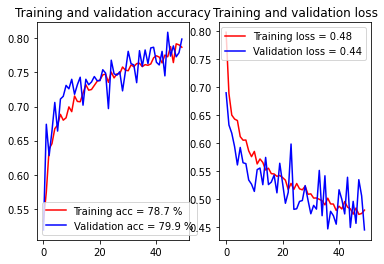

In [71]:
plot_acc_loss(history_a.history)

รูปที่ 4.18 กราฟความแม่นยำและค่าสูญเสียจากข้อมูลฝึกและตรวจสอบ

<div style=".noindent"><b>ตัวอย่าง 4.5</b></div>

พิจารณาปัญหาการจำแนกประเภทที่มีมากกว่าสอง โดยใช้ข้อมูลภาพมือที่แทนวัตถุ 3 ประเภทคือ ก้อนหิน กรรไกร และกระดาษ 
ซึ่งเราคงเคยเล่นในสมัยเด็ก ใช้ข้อมูลภาพที่สร้างโดยคอมพิวเตอร์จาก 
https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset 
ตัวอย่างของภาพแสดงในรูปที่ 4.19 สามารถโหลดข้อมูลจากเว็บเพื่อศึกษาได้โดยให้เครดิตกับเจ้าของข้อมูลคือ
Laurence Moroney https://laurencemoroney.com/ 


<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1MgZft29dwp0ZZIe6BZIsrt6XC68uHjQQ" width=650 />
</p>
<div align="center">รูปที่ 4.19 ตัวอย่างภาพมือที่แทนก้อนหิน กรรไกร กระดาษ</div>

วิธีการที่สะดวกคือใช้โปรแกรม <code>wget</code> เพื่อดาวน์โหลดไฟล์เก็บที่ไดเรคทอรี <code>/tmp</code>


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2022-06-08 11:46:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.200.16, 216.58.221.208, 142.250.199.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.200.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   922KB/s    in 3m 39s  

2022-06-08 11:49:47 (895 KB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2022-06-08 11:49:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.199.240, 216.58.221.208, 142.250.199.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.199.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/r

แยกไดเรคทอรีสำหรับภาพฝึกและทดสอบ ภายในไดเรคทอรีย่อยสำหรับภาพฝึก แยกหมวดหมู่สำหรับภาพก้อนหิน กระดาษ กรรไกร

In [5]:
import os
import zipfile
local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()
local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [6]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')
print('จำนวนภาพก้อนหินทั้งหมด :', len(os.listdir(rock_dir)))
print('จำนวนภาพกระดาษทั้งหมด :', len(os.listdir(paper_dir)))
print('จำนวนภาพกรรไกรทั้งหมด :', len(os.listdir(scissors_dir)))
rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

จำนวนภาพก้อนหินทั้งหมด : 840
จำนวนภาพกระดาษทั้งหมด : 840
จำนวนภาพกรรไกรทั้งหมด : 840


ประมวลผลภาพอินพุตโดยใช้ <code>ImageDataGenerator</code> เช่นเดียวกับตัวอย่าง 4.4 
เพียงแต่เปลี่ยนอาร์กิวเมนต์ <code>class_mode='categorical'</code> 
เนื่องจากคลาสในตัวอย่างนี้ไม่เป็นแบบทวิภาค แต่มีจำนวน 3 คลาส

In [7]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(rescale = 1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,target_size=(150,150),class_mode='categorical',batch_size=126
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,target_size=(150,150),class_mode='categorical',batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


สร้างโมเดล CNN ประกอบด้วยชั้นสังวัตนาการและพูลลิง 4 คู่ และปิดท้ายด้วยชั้นเชื่อมต่อเต็ม 
โดยมีดรอปเอาต์เพื่อลดผลการฟิตเกิน ผู้อ่านสามารถทดลองปรับไฮเปอร์พารามิเตอร์ตามต้องการ 

In [10]:
model_rps = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

In [11]:
model_rps.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
=================================================================
Total params: 3,473,475
Trainable params: 3,473,475
Non-trainable params: 0
_________________________________________________________________
```

ขั้นตอนต่อไปเป็นการคอมไพล์โมเดล โดยกำหนดอาร์กิวเมนต์ฟังก์ชันสูญเสียแบบ 
<code>categorical_crossentropy</code> เลือกตัวหาค่าเหมาะที่สุดตามต้องการ 
หลังจากนั้นทดลองฝึกโมเดล 25 รอบ (อาจใช้เวลานานขึ้นกับสมรรถนะคอมพิวเตอร์ที่ใช้)

In [12]:
model_rps.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [13]:
history_rps = model_rps.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

Epoch 1/25
20/20 [==============================] - 52s 2s/step - loss: 1.3081 - accuracy: 0.3631 - val_loss: 1.1010 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 52s 3s/step - loss: 1.0921 - accuracy: 0.3770 - val_loss: 1.0308 - val_accuracy: 0.7285
Epoch 3/25
20/20 [==============================] - 57s 3s/step - loss: 1.0839 - accuracy: 0.4893 - val_loss: 0.8145 - val_accuracy: 0.4435
Epoch 4/25
20/20 [==============================] - 51s 3s/step - loss: 0.9450 - accuracy: 0.5286 - val_loss: 0.8513 - val_accuracy: 0.4919
Epoch 5/25
20/20 [==============================] - 52s 3s/step - loss: 0.8494 - accuracy: 0.5980 - val_loss: 0.3650 - val_accuracy: 0.9892
Epoch 6/25
20/20 [==============================] - 52s 3s/step - loss: 0.7399 - accuracy: 0.6790 - val_loss: 0.2772 - val_accuracy: 0.9785
Epoch 7/25
20/20 [==============================] - 49s 2s/step - loss: 0.5650 - accuracy: 0.7468 - val_loss: 0.2052 - val_accuracy: 0.9731
Epoch 8/25
20/20 [==

```{admonition} ตัวอย่างเอาต์พุต
:class: tip
<div style="font-size: 12pt">
<br>Epoch 1/25
<br>20/20 [===...===] - 52s 2s/step - loss: 1.3081 - accuracy: 0.3631 - val_loss: 1.1010 - val_accuracy: 0.3333
<br>Epoch 2/25
<br>20/20 [===...===] - 52s 3s/step - loss: 1.0921 - accuracy: 0.3770 - val_loss: 1.0308 - val_accuracy: 0.7285
<br>:
<br>Epoch 25/25
<br>20/20 [===...===] - 59s 3s/step - loss: 0.0608 - accuracy: 0.9813 - val_loss: 0.0558 - val_accuracy: 0.9758
</div>
```

หากต้องการบันทึกโมเดลที่ฝึกแล้ว ใช้คำสั่ง

In [16]:
model_rps.save("model_rps.h5")

หรือหากต้องการเก็บข้อมูลจากการฝึกในดิกชันนารี <code>history_rps</code>

In [15]:
import json
with open('history_rps.json', 'w') as file:
    json.dump(history_rps.history, file)

คำสั่งโหลดโมเดลที่บันทึกไว้

In [ ]:
from tensorflow.keras.models import load_model
model_rps_trained = load_model('model_rps.h5')

คำสั่งโหลดข้อมูลการฝึก

In [18]:
with open('history_rps.json') as json_file:
    saved_history_rps = json.load(json_file)

ตรวจสอบข้อมูลจากการฝึกดังในรูปที่ 4.20 จะเห็นว่าโดยรวมแล้วแนวโน้มของความแม่นยำและค่าสูญเสียจากข้อมูลฝึกและตรวจสอบเป็นไปในทิศทางเดียวกัน 
เป็นสัญญาณที่ดีว่าการฟิตเกินไม่ใช่ปัญหา


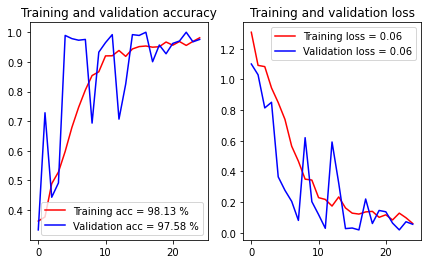

In [24]:
plot_acc_loss(history_rps.history)
#plot_acc_loss(saved_history_rps)

รูปที่ 4.20 ความแม่นยำและค่าสูญเสียจากการฝึกโมเดลในตัวอย่าง 4.5

ผู้อ่านสามารถทดสอบจากภาพมือของตนเอง โดยถ่ายภาพมือที่ทำเป็นรูปอย่างใดอย่างหนึ่งใน 3 ประเภทแล้วใส่ในไดเรคทอรี <code>test</code> 
ในเซลล์ด้านล่างตั้งชื่อตัวแปร <code>fn</code> ให้ตรงกับชื่อไฟล์ และรันโค้ดในเซลล์

paper.jpg
ผลพยากรณ์ --> กรรไกร


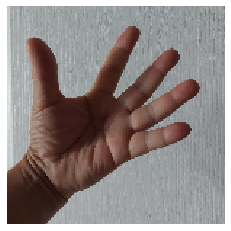

In [72]:
import numpy as np
from keras.preprocessing import image
import keras 
fn = "paper.jpg"
# predicting images
path = "test/" + fn
img = tf.keras.utils.load_img(path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_rps.predict(images, batch_size=10)
print(fn)
if np.argmax(classes) == 0:
    print("ผลพยากรณ์ --> ก้อนหิน")
elif np.argmax(classes) == 1:
    print("ผลพยากรณ์ --> กระดาษ")
elif np.argmax(classes) == 2:
    print("ผลพยากรณ์ --> กรรไกร")

## 4.4 โมเดลกรณีศึกษา

ในหัวข้อนี้จะยกตัวอย่างโมเดล CNN ตั้งแต่ยุคบุกเบิกที่ประสบความสำเร็จและเป็นต้นแบบให้กับโมเดลสมัยใหม่ 
บางโมเดลสามารถดาวน์โหลดและดัดแปลงแก้ไขเพื่อนำมาประยุกต์ใช้ในงานของตนเองได้ 

### 4.4.1 LeNet-5

LeNet-5 คือโมเดล CNN พื้นฐานที่นำเสนอโดย Yann Lecun และคณะ {cite}`Lecun_1989` ในปี ค.ศ. 1989 จัดได้ว่าเป็นการเริ่มต้นของสถาปัตยกรรม CNN 
ที่ประสบผลสำเร็จในการจำแนกตัวเลขที่เขียนด้วยมือ ถูกใช้โดยบริการไปรษณีย์ของสหรัฐอเมริกาเพื่อจำนกตัวเลขรหัสไปรษณีย์ที่ลูกค้าเขียน

รูปที่ 4.21 แสดงโครงสร้างแต่ละชั้นของโมเดล LeNet-5 จะเห็นว่าคล้ายกับตัวอย่างที่แสดงในรูปที่ 4.9 ด้านบน เพียงแต่อินพุตจะเป็นภาพขาวดำ 
และในยุคเริ่มต้นนิยมทำพูลลิงแบบเฉลี่ย สิ่งหนึ่งที่สังเกตได้คือเมื่อโมเดลเข้าสู่ลำดับชั้นที่ลึกขึ้น ค่าความกว้างและยาวของข้อมูลจะลดลงแต่ด้านความลึกจะมากขึ้น
สำหรับฟังก์ชันกระตุ้นในยุคเริ่มต้นนั้นนิยมใช้ <code>sigmoid()</code> หรือ <code>tanh()</code>
และในชั้นเอาต์พุตก็ใช้ฟังก์ชันกระตุ้นที่แตกต่างจาก <code>softmax()</code> 
ปัจจุบันการใช้ CNN ที่มีโครงสร้างเหมือน LeNet-5 มักจะพบเห็นฟังก์ชันกระตุ้น <code>ReLU()</code> ในชั้นสังวัตนาการ ร่วมกับการทำพูลลิงแบบค่ามากสุด 
ส่วนชั้นสุดท้ายเป็นแบบ <code>softmax()</code> ในกรณีการจำแนกหลายประเภท 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1xZXRx62CVNa-6svM9P4iETQcNLYi8Tth" width=750 />
</p>
<div align="center">รูปที่ 4.21 โครงสร้างของ LeNet-5</div>

### 4.4.2 AlexNet

AlexNet คือชื่อของ CNN ที่ออกแบบโดย  Alex Krizhevsky ร่วมกับ lya Sutskever และ Geoffrey Hinton {cite}`AlexNet_2012`
ส่งเข้าแข่งขันในรายการ the ImageNet Large Scale Visual Recognition Challenge เมื่อวันที่ 30 กันยายน ค.ศ. 
2012 ได้จัดอยู่ใน 5 อันดับแรกที่มีค่าผิดพลาดน้อยที่สุดคือ 15.3 % รูปที่ 4.22 แสดงโครงสร้างของ AlexNet 
ที่ิอินพุตเป็นภาพสีขนาด 227x227x3 ผ่านชั้นสังวัตนาการแรกที่ตั้งค่าช่วงก้าว 4 ทำให้ขนาดภาพลดลงแต่มีความลึกเพิ่มขึ้นตามจำนวนเคอร์เนล 
หลังจากนั้นผ่านชั้นพูลลิงและชั้นสังวัตนาการอีกหลายชั้น หลังจากชั้นพูลลิงสุดท้ายจึงคลี่เอาต์พุตออกและใช้ชั้นเชื่อมต่อเต็มขนาด 9216 
เซลล์และลดลงเหลือ 4096 เซลล์อีก 2 ชั้นก่อนส่งออกเอาต์พุตที่จำแนก 1000 ประเภทโดยฟังก์ชันกระตุ้น <code>softmax()</code> 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1k8kboVSyepyJ1-rJYhurwlH1eaIdJ3Ry" width=750 />
</p>
<div align="center">รูปที่ 4.22 โครงสร้างของ AlexNet</div>

AlexNet จัดได้ว่าเป็นโมเดลที่มีความลึกสำหรับสมรรถนะตัวประมวลผลในยุคนั้น มีพารามิเตอร์โดยประมาณถึง 60 ล้านตัว
จึงต้องมีการใช้ GPU ช่วยในการฝึก 

### 4.4.3 VGG-16 และ VGG-19

VGG-16 คือโมเดล CNN ที่นำเสนอโดย Karen Simonyan และ Andrew Zisserman {cite}`VGG_2014` จาก the University of Oxford 
ในการแข่งขัน the ILSVRC ImageNet Challenge ปี ค.ศ. 2014 ชั้นสังวัตนาการของ VGG-16 มีรูปแบบเดียวคือใช้เคอร์เนลขนาด 
3 x 3 ช่วงก้าว 1 และ padding=same ส่วนชั้นพูลลิงใช้เคอร์เนลขนาด 2 x 2 ช่วงก้าว 2 ทั้งหมด อย่างไรก็ตาม VGG-16 เป็นโมเดล CNN
ที่มีความลึกและมีพารามิเตอร์มากถึงประมาณ 138 ล้านตัว รูปที่ 4.23 แสดงโครงสร้างของ VGG-16 (ภาพจาก 
https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c) 

<p />  
<p align="center">
<img src="https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png" width=550 />
</p>
<div align="center">รูปที่ 4.23 <a href="https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c">โครงสร้างของ VGG-16</a></div>

VGG-19 มีโครงสร้างคล้าย VGG-16 แต่มีความลึกมากขึ้น
<p />

<div style=".noindent"><b>ตัวอย่าง 4.6</b></div> 

VGG-19 เป็นหนึ่งในโมเดลที่สามารถนำเข้าจากไลบรารี TF ได้โดยตรง เนื่องจากเป็นโมเดลขนาดใหญ่จึงใช้เวลาในการโหลด 
ทั้งนี้ขึ้นกับความเร็วการเชื่อมต่ออินเทอร์เน็ต

In [60]:
from tensorflow.keras.applications import VGG19
vgg_model = VGG19()

574726144/574710816 [==============================] - 41s 0us/step


แสดงโครงสร้างโดยใช้เมธอด <code>summary()</code>

In [61]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

```
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_conv4 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 28, 28, 256)       0         
                                                                 
 block4_conv1 (Conv2D)       (None, 28, 28, 512)       1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_conv4 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 14, 14, 512)       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv4 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 predictions (Dense)         (None, 1000)              4097000   
                                                                 
=================================================================
Total params: 143,667,240
Trainable params: 143,667,240
Non-trainable params: 0
_________________________________________________________________
```

เพื่อการศึกษาภายในโมเดล สร้างโมเดลใหม่ที่มีเอาต์พุตเป็นเอาต์พุตของแต่ละชั้น 

In [62]:
from tensorflow.keras.models import Model

In [63]:
vgg_input = vgg_model.input
vgg_layers = vgg_model.layers
layer_outputs = [layer.output for layer in vgg_layers]
features = Model(inputs=vgg_input, outputs = layer_outputs)

เลือกภาพที่เราชอบเพื่อเป็นอินพุตของโมเดล ใส่ในไดเรคทอรีย่อย <code>content</code> 
ในตัวอย่างนี้ผู้เขียนใช้ไฟล์ภาพ <code>dollar_sink.jpg</code> แสดงในรูปที่ 4.24

(-0.5, 1506.5, 1234.5, -0.5)

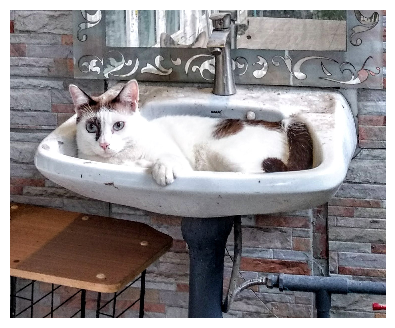

In [64]:
from PIL import Image
my_image = "content/dollar_sink.jpg"
image = np.array(plt.imread(my_image))
my_image = Image.fromarray(image) 
plt.imshow(image)
plt.axis('off')

รูปที่ 4.24 ภาพแมวนอนในอ่างล้างหน้าสำหรับทดสอบโมเดล VGG-19

โหลดภาพและประมวลผลเบื้องต้นเพื่อจัดภาพให้เป็นอินพุต $x$ สำหรับโมเดล 

In [65]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

img_path = 'content/dollar_sink.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

ผ่านอินพุตเข้าสู่โมเดล <code>features</code> เพื่อแสดงผลเอาต์พุตของแต่ละชั้น

In [66]:
extracted_features = features(x)

เราสามารถแสดงบางภาพเอาต์พุตของชั้นที่ต้องการได้ดังในรูปที่ 4.25 โดยเปลี่ยนค่าตัวแปร <code>index</code> ในโค้ดด้านล่าง 
โดย <code>index=0</code> คือชั้นอินพุต 
สังเกตว่าเมื่อเลือกค่า <code>index</code> มากขึ้น เอาต์พุตจะมาจากชั้นที่ลึกขึ้นในโมเดล รายละเอียดของภาพจะลดลง

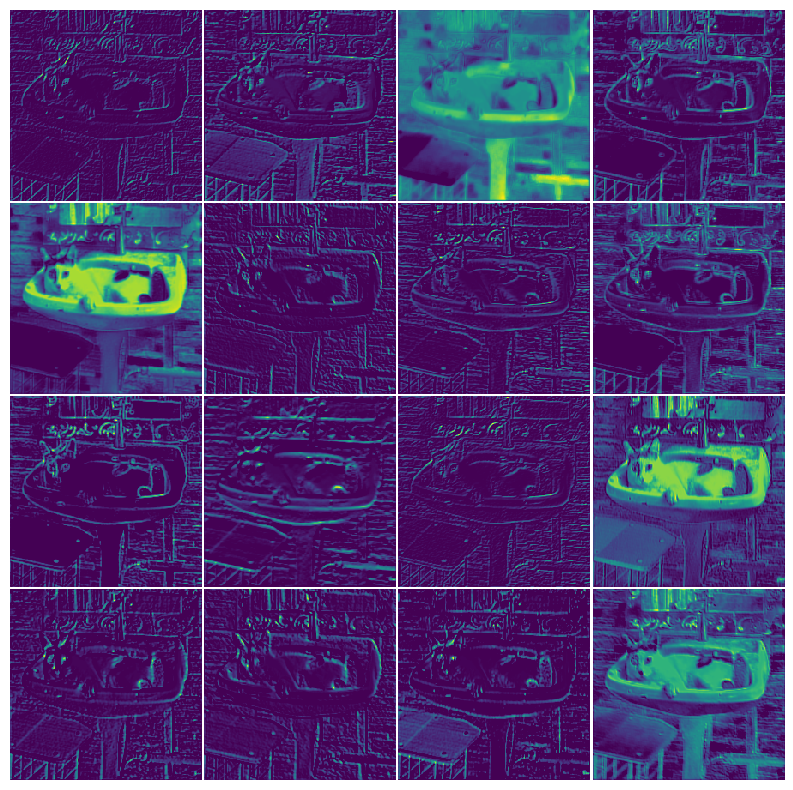

In [67]:
index = 2
fi = extracted_features[index]
#print('\n fi.shape: ',fi.shape)
imgs = fi[0,:,:]
plt.figure(figsize=(10,10))
if index==0:
    for n in range(3):
        ax = plt.subplot(1,3,n+1)
        plt.imshow(imgs[:,:,n])
        plt.axis('off') 
else:
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(imgs[:,:,n])
        plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)


<div align="center">รูปที่ 4.25 เอาต์พุตของชั้นแฝงในโมเดล VGG-19</div>

อีกวิธีการหนึ่งในการแสดงเอาต์พุตของแต่ละชั้นในโมเดลคือการเข้าถึงโดยชื่อของชั้น (ดูจาก <code>vgg_model.summary()</code> ด้านบน) 
ในโค้ดด้านล่างนี้เปลี่ยนชื่อตัวแปร <code>layer_name</code> เป็นชั้นที่ต้องการ รูปที่ 4.26 แสดงเอาต์พุตบางภาพของชั้นนั้น

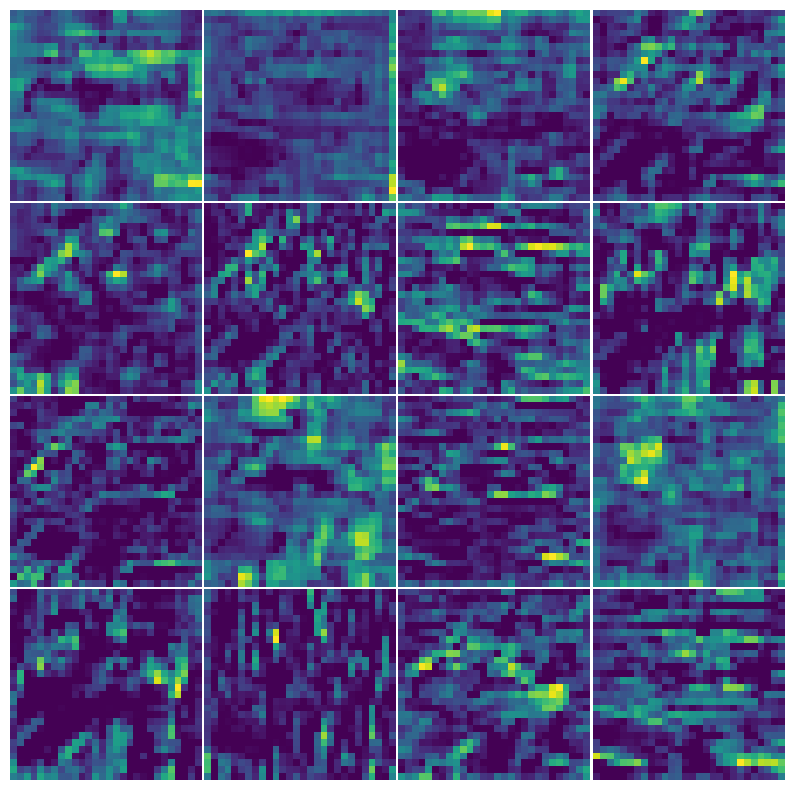

In [68]:
layer_name = 'block3_pool'
features_model = Model(inputs=features.input, outputs=features.get_layer(layer_name).output)
selected_features = features_model.predict(x)
# Visualise some features from the extracted layer output
imgs = selected_features[0,:,:]
plt.figure(figsize=(10,10))
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(imgs[:,:,n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

<div align="center">รูปที่ 4.25 เอาต์พุตของชั้นแฝงในโมเดล VGG-19 ที่เลือกโดยชื่อชั้น</div> 

ขั้นสุดท้ายคือต้องการดูผลการพยากรณ์ของภาพที่เลือก VGG-19 สามารถจำแนกวัตถุในภาพได้ 1000 ประเภท 
เอาต์พุตที่ได้เป็นเวกเตอร์ขนาด 1000 ที่สมาชิกคือความน่าจะเป็นขององค์ประกอบในภาพว่าเป็นประเภทใด 
เราสามารถตรวจสอบหมายเลขของประเภทที่มีความน่าจะเป็นสูงสุดได้โดยคำสั่ง

In [52]:
prediction=vgg_model.predict(x,verbose=0)
output_class = np.argmax(prediction)
print("ภาพเป็นประเภท {} ความน่าจะเป็น {}".format(output_class,prediction[0][output_class]))

ภาพเป็นประเภท 896 ความน่าจะเป็น 0.37285181879997253


ปัญหาคือตัวเลข 896 ไม่สื่อความหมายว่าเป็นภาพของอะไร VGG-19 มีฟังก์ชันสนับสนุนทีสามารถตรวจสอบ 5 ประเภทที่มีความน่าจะเป็นสูงสุด 
โดยนำเข้าฟังก์ชัน <code>decode_predictions()</code> 

In [53]:
from tensorflow.keras.applications.vgg19 import decode_predictions

และตรวจสอบผลการพยากรณ์ได้ดังนี้ (เอาต์พุตจะแสดง 5 ประเภทที่มีความน่าจะเป็นสูงสุด)

In [54]:
decode_predictions(prediction)

[[('n04553703', 'washbasin', 0.37285182),
  ('n04493381', 'tub', 0.10058041),
  ('n02797295', 'barrow', 0.08947974),
  ('n02437616', 'llama', 0.049459655),
  ('n02403003', 'ox', 0.037001695)]]

เป็นที่น่าสนใจว่าแม้โมเดลที่มีความลึกมากและผ่านการฝึกมาอย่างดีแล้วก็ยังไม่สามารถพยากรณ์ว่ามีแมวในภาพนี้ได้ 
อย่างไรก็ตามจะเห็นว่าประเภทที่โมเดลพยากรณ์ด้วยความน่าจะเป็นสูงสุดอันดับ 1 คืออ่างล้างหน้า ซึ่งเป็นวัตถุที่เป็นลักษณะเด่นในภาพนี้ 
(ส่วนอันดับที่ 5 คือวัว แมวที่มีลักษณะจุดแต้มเช่นนีัมักถูกเรียกว่า "แมวลายวัว")

### 4.4.4 ResNets

โครงข่ายประสาทเทียมที่มีความลึกมากเป็นอุปสรรคในการฝึกเนื่องจากปัญหาการมีค่ามากและการหายไปของเกรเดียนต์ 
ในหัวข้อนี้เราจะศึกษาวิธีข้ามการเชื่อมต่อ (skip connection) หรือสร้างทางลัด (shortcut) ในบางชั้น 
โครงสร้างลักษณะนี้มีชื่อเรียกว่า <em>โครงข่ายตกค้าง (residual networks)</em> นิยมเรียกโดยย่อว่า ResNets {cite}`Resnet_2016`
ซึ่งต่อไปจะเรียกโดยชื่อนี้ 

ส่วนประกอบสำคัญในโครงสร้างของ ResNets เรียกว่า <em>บล็อกตกค้าง (residual block)</em> ดังแสดงในรูปที่ 4.26 
จะเห็นว่าส่วนที่แตกต่างจากโครงข่ายประสาทเทียมที่เราได้ศึกษามา หรือที่ในบทความนำเสนอ ResNets เรียกว่า โครงข่ายธรรมดา (plain) 
คือจะมีการเชื่อมต่อข้ามจาก $a^{[l]}$ ไปยังเอาต์พุตส่วนเชิงเส้น $z^{[l+2]}$ 
ซึ่งการเชื่อมต่อข้ามในลักษณะนี้สามารถช่วยในการฝึกโครงข่ายที่มีความลึกมากได้ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1hNxS6C1C7PI_B-rqObaOfyw6_RC-ldHf" width=750 />
</p>
<p />

<div align="center">รูปที่ 4.26 บล็อกตกค้างที่เป็นส่วนประกอบสำคัญของ ResNets</div>

เราสามารถอธิบายอย่างง่ายว่าทำไมบล็อกตกค้างทำงานได้ดี พิจารณาเอาต์พุตของบล็อก

$$
a^{[l+2]} = g(z^{[l+2]}+a^{[l]}) \tag{4.4}
$$

โดย

$$
z^{[l+2]} = W^{[l+2]}a^{[l+1]}+b^{[l+2]} \tag{4.5}
$$

สมมุติว่าการใช้เรกูลาร์ไลเซชันมีผลทำให้ค่าน้ำหนัก $W^{[l+2]}$ และค่าเอนเอียง $b^{[l+2]}$ มีค่าเหลือน้อยมาก 
ดังนั้น $z^{[l+2]} \approx 0$ และเมื่อกำหนด $g(.)$ เป็นฟังก์ชัน ReLU จะได้ว่า

$$
a^{[l+2]} \approx a^{[l]} \tag{4.6}
$$

กล่าวคือบล็อกทำหน้าที่เหมือนกับฟังก์ชันเอกลักษณ์ เปรียบเสมือนว่าความลึกของโครงข่ายลดลงและช่วยเอื้ออำนวยให้การฝึกง่ายขึ้น 
ส่วนในกรณีที่บล็อกสามารถเรียนรู้ได้อย่างมีประสิทธิภาพ ResNets ก็สามารถใช้ประโยชน์จากทุกชั้นได้อย่างเต็มที่

รูปที่ 4.27 แสดงตัวอย่างการใช้บล็อกตกค้างเพื่อสร้าง ResNets เปรียบเทียบกับโครงข่ายธรรมดา 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1XGyVMfhXgvxUWVAbsOlg093LVrnf6pNp" width=750 />
</p>
<p />
<div align="center">รูปที่ 4.27 เปรียบเทียบระหว่างโครงข่ายธรรมดากับ ResNets</div>

<div style=".noindent"><b>ตัวอย่าง 4.7</b></div>

```{admonition} หมายเหตุ : 
ตัวอย่างเป็นเพียงส่วนหนึ่งจากแบบฝึกหัดของวิชา Convolutional Neural Networks สอนโดย Prof.Andrew NG ใน Coursera 
สำหรับรายละเอียดรวมถึงข้อมูลฝึกและโมเดลที่ผ่านการฝึกแล้ว ขอให้ผู้อ่านลงทะเบียนเรียนในรายวิชานี้
```

ตัวอย่างนี้เป็นการทดลองสร้างโมเดล ResNets จากบล็อกพื้นฐานเพื่อประกอบเข้าเป็นโครงข่ายที่มีความลึก 50 ชั้นแฝง นำเข้าไลบรารีทั้งหมดที่ใช้งาน
(ต้องการไฟล์เสริม <code>resnets_utils.py</code> ในไดเรคทอรีเดียวกับสมุดบันทึกนี้)


In [70]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

%matplotlib inline

บล็อกพื้นฐานประกอบด้วย <em>บล็อกเอกลักษณ์ (identity block)</em> ดังแสดงในรูปที่ 4.28 โดยในตัวอย่างนี้จะแตกต่างจากบล็อกตกค้างในรูปที่ 4.26 
ตรงที่เส้นทางลัดจะข้ามชั้นจำนวน 3 ชั้น รายละเอียดของแต่ละบล็อกย่อยดูได้จากโค้ดในเซลล์ด้านล่าง 
โดยสร้างเป็นฟังก์ชัน <code>identity_block()</code> 
สังเกตว่าจะใช้ API เชิงฟังก์ชันพื่อสร้างแต่ละชั้น การสร้างเส้นทางลัดทำได้โดยกำหนดค่าอินพุต <code>X</code> ให้กับตัวแปร 
<code>X_shortcut</code> ในช่วงต้น ซึ่งถูกเพิ่มให้กับเทนเซอร์ในส่วนท้ายก่อนจะผ่านเข้าสู่ฟังก์ชันกระตุ้น ReLU 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1J6kivWDQfqvXUwOxqMStqp_jcohd3JwZ" width=750 />
</p>
<p />
<div align="center">รูปที่ 4.28 บล็อกเอกลักษณ์ที่เส้นทางลัดข้าม 3 ชั้น</div>

In [4]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):    
    F1, F2, F3 = filters    
    X_shortcut = X
    cache = []    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)    
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    ## Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    return X

ต่อมาคือการสร้างบล็อกเชิงสังวัตนาการที่มีโครงสร้างดังแสดงในรูปที่ 4.29 สิ่งที่แตกต่างจากบล็อกเอกลักษณ์คือมีชั้นสังวัตนาการและแบตช์นอร์มในเส้นทางลัด 
จะใช้บล็อกนี้เมื่อมิติของอินพุตและเอาต์พุตแตกต่างกัน โดยบล็อกย่อยที่อยู่ในเส้นทางลัดทำหน้าที่ปรับขนาดอินพุตเพื่อให้สามารถบวกกันได้ในขั้นสุดท้าย 
โค้ดสำหรับฟังก์ชัน <code>convolutional_block()</code> เป็นดังนี้

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1ipgjAk0SwsBdltN5HkBWCb7RqAvyWc4R" width=750 />
</p>
<p />
<div align="center">รูปที่ 4.29 บล็อกเชิงสังวัตนาการ</div>

In [5]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):    
    F1, F2, F3 = filters    
    X_shortcut = X
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    ## Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)    
    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)    
    return X

ขั้นสุดท้ายคือประกอบบล็อกเอกลักษณ์และบล็อกเชิงสังวัตนาการที่สร้างไว้เข้าเป็นโมเดล ResNet 50 ชั้น โดยมีสถาปัตยกรรมดังแสดงในรูปที่ 4.30 
เขียนแทนโดย ID blk และ Conv blk สำหรับบล็อกที่เขียนว่า ID blk x n โดย n คือเลข 2,3,5 
หมายความว่าใช้บล็อกเอกลักษณ์มาซ้อนกันเป็นจำนวน n ทั้งหมดเขียนเป็นฟังก์ชัน <code>ResNet50()</code> ดังนี้

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1lM49K4J3Vzp4pKX-UqqDy390OSDq7lx0" width=750 />
</p>
<p />
<div align="center">รูปที่ 4.30 โมเดล ResNet 50 ชั้น</div>

In [13]:
def ResNet50(input_shape = (150,150,3), classes = 3):    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])    
    ## Stage 3 
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])    
    ## Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    ## Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    ## AVGPOOL 
    X = AveragePooling2D((2, 2))(X)    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)    
    # Create model
    model = Model(inputs = X_input, outputs = X)
    return model        

ใช้ฟังก์ชัน <code>ResNet50()</code> สร้างโมเดลและตรวจสอบโดยเมธอด <code>summary()</code> 

```{admonition} หมายเหตุ :
เนื่องจากเอาต์พุตมีความยาวมากจึงไม่สามารถแสดงในหนังสือได้ทั้งหมด
```

In [17]:
resnet50_model = ResNet50(input_shape = (150,150, 3), classes = 3)
print(resnet50_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 75, 75, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                            

 activation_57 (Activation)     (None, 37, 37, 64)   0           ['batch_normalization_62[0][0]'] 
                                                                                                  
 conv2d_63 (Conv2D)             (None, 37, 37, 256)  16640       ['activation_57[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 37, 37, 256)  1024       ['conv2d_63[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 37, 37, 256)  0           ['activation_55[0][0]',          
                                                                  'batch_normalization_63[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 add_21 (Add)                   (None, 19, 19, 512)  0           ['activation_64[0][0]',          
                                                                  'batch_normalization_73[0][0]'] 
                                                                                                  
 activation_67 (Activation)     (None, 19, 19, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 19, 19, 128)  65664       ['activation_67[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 19, 19, 128)  512        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

                                )                                 'batch_normalization_83[0][0]'] 
                                                                                                  
 activation_76 (Activation)     (None, 10, 10, 1024  0           ['add_24[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 10, 10, 256)  262400      ['activation_76[0][0]']          
                                                                                                  
 batch_normalization_84 (BatchN  (None, 10, 10, 256)  1024       ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_93 (Conv2D)             (None, 10, 10, 256)  262400      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_93 (BatchN  (None, 10, 10, 256)  1024       ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_86 (Activation)     (None, 10, 10, 256)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 10, 10, 256)  590080      ['activation_86[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 10, 10, 256)  1024       ['conv2d_94[0][0]']              
 ormalizat

                                                                                                  
 activation_95 (Activation)     (None, 5, 5, 512)    0           ['batch_normalization_103[0][0]']
                                                                                                  
 conv2d_104 (Conv2D)            (None, 5, 5, 512)    2359808     ['activation_95[0][0]']          
                                                                                                  
 batch_normalization_104 (Batch  (None, 5, 5, 512)   2048        ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_96 (Activation)     (None, 5, 5, 512)    0           ['batch_normalization_104[0][0]']
                                                                                                  
 conv2d_10

```
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 75, 75, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_53 (BatchN  (None, 75, 75, 64)  256         ['conv2d_53[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_49 (Activation)     (None, 75, 75, 64)   0           ['batch_normalization_53[0][0]'] 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 37, 37, 64)  0           ['activation_49[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 37, 37, 64)   4160        ['max_pooling2d_1[0][0]']        
                                                                                                  
 batch_normalization_54 (BatchN  (None, 37, 37, 64)  256         ['conv2d_54[0][0]']              
 ormalization) 

                                        :
                                        :
                                        :
conv2d_105 (Conv2D)            (None, 5, 5, 2048)   1050624     ['activation_96[0][0]']          
                                                                                                  
 batch_normalization_105 (Batch  (None, 5, 5, 2048)  8192        ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_31 (Add)                   (None, 5, 5, 2048)   0           ['activation_94[0][0]',          
                                                                  'batch_normalization_105[0][0]']
                                                                                                  
 activation_97 (Activation)     (None, 5, 5, 2048)   0           ['add_31[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 2, 2, 2048)  0           ['activation_97[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 8192)         0           ['average_pooling2d_1[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 3)            24579       ['flatten_1[0][0]']              
                                                                                                  
==================================================================================================
Total params: 23,612,291
Trainable params: 23,559,171
Non-trainable params: 53,120
__________________________________________________________________________________________________
None    
```

คอมไพล์โมเดลโดยเลือกตัวหาค่าเหมาะที่สุดแบบ <code>'adam'</code>
และฟังก์ชันสูญเสีย <code>'categorical_crossentropy'</code> 

In [18]:
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ต้องการทดสอบโมเดลนี้กับภาพมือที่แทนหิน กระดาษ กรรไกร จากตัวอย่าง 4.5 โดยใช้ข้อมูลที่จัดเตรียมไว้แล้วจากตัวอย่างนั้น 
เนื่องจากการฝึกโมเดลที่มีความลึก 50 ชั้นจะใช้เวลานาน โดยเฉพาะหากคอมพิวเตอร์มีสมรรถนะไม่สูงและไม่มี GPU 
ดังนั้นในตัวอย่างนี้จึงฝึกแค่จำนวน 10 รอบเพื่อเป็นการสาธิตเท่านั้น  

In [19]:
history_resnet50 = resnet50_model.fit(train_generator, epochs=10, steps_per_epoch=20, validation_data = validation_generator, verbose = 0, validation_steps=3)

Epoch 1/10
20/20 [==============================] - 168s 8s/step - loss: 3.1653 - accuracy: 0.4472 - val_loss: 0.8754 - val_accuracy: 0.5565
Epoch 2/10
20/20 [==============================] - 163s 8s/step - loss: 0.6855 - accuracy: 0.7091 - val_loss: 0.9722 - val_accuracy: 0.6183
Epoch 3/10
20/20 [==============================] - 163s 8s/step - loss: 0.3254 - accuracy: 0.8798 - val_loss: 1.5461 - val_accuracy: 0.6344
Epoch 4/10
20/20 [==============================] - 165s 8s/step - loss: 0.1482 - accuracy: 0.9488 - val_loss: 1.0623 - val_accuracy: 0.7043
Epoch 5/10
20/20 [==============================] - 166s 8s/step - loss: 0.1336 - accuracy: 0.9548 - val_loss: 1.3084 - val_accuracy: 0.5806
Epoch 6/10
20/20 [==============================] - 165s 8s/step - loss: 0.0864 - accuracy: 0.9722 - val_loss: 1.7897 - val_accuracy: 0.5376
Epoch 7/10
20/20 [==============================] - 168s 8s/step - loss: 0.0642 - accuracy: 0.9782 - val_loss: 0.7630 - val_accuracy: 0.7849
Epoch 8/10
20

หากต้องการบันทึกโมเดลที่ฝึกแล้ว ใช้คำสั่ง 

In [20]:
resnet50_model.save("resnet50.h5")

โค้ดในการอ่านโมเดลจากไฟล์

In [ ]:
from tensorflow.keras.models import load_model
resnet50_model_trained = load_model('resnet50.h5')

พล็อตค่าความแม่นยำและค่าสูญเสียจากการฝึกได้ดังรูปที่ 4.31 

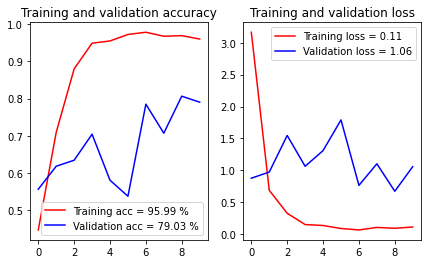

In [24]:
plot_acc_loss(history_resnet50.history)

รูปที่ 4.31 ความแม่นยำและค่าสูญเสียจากโมเดล ResNet50

ผู้อ่านสามารถทดสอบจากภาพมือของตนเอง โดยถ่ายภาพมือที่ทำเป็นรูปอย่างใดอย่างหนึ่งใน 3 ประเภทแล้วใส่ในไดเรคทอรี <code>test</code> 
ในเซลล์ด้านล่างตั้งชื่อตัวแปร <code>fn</code> ให้ตรงกับชื่อไฟล์ และรันโค้ดในเซลล์


1/1 [==============================] - 0s 40ms/step
scissors.jpg
ผลพยากรณ์ --> ก้อนหิน


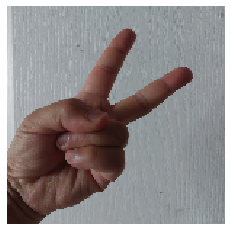

In [36]:
import numpy as np
from keras.preprocessing import image
import keras 
fn = "scissors.jpg"
# predicting images
path = "test/" + fn
img = tf.keras.utils.load_img(path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = resnet50_model.predict(images, batch_size=10)
print(fn)
if np.argmax(classes) == 0:
    print("ผลพยากรณ์ --> ก้อนหิน")
elif np.argmax(classes) == 1:
    print("ผลพยากรณ์ --> กระดาษ")
elif np.argmax(classes) == 2:
    print("ผลพยากรณ์ --> กรรไกร")

```{admonition} หมายเหตุ :
ในตัวอย่างนี้ต้องการแสดงการสร้างโมเดลเท่านั้น การพยากรณ์ไม่แม่นยำเนื่องจากฝึกเป็นจำนวนรอบน้อยและใช้ข้อมูลภาพไม่มาก
```

### 4.4.5 โครงข่ายอินเซปชัน

<em>โครงข่ายอินเซปชัน (inception networks)</em>  เป็นโครงข่ายประสาทเทียมเชิงลึกที่ผู้นำเสนอได้ชื่อมาจากมีม 
["We need to go deeper"](https://knowyourmeme.com/memes/we-need-to-go-deeper) จากภาพยนต์เรื่องอินเซปชัน 
 ดังนั้นจึงขอเรียกทับศัพท์เนื่องจากแปลแล้วไม่สื่อความหมายที่ต้องการ 
เป้าหมายของอินเซปชันคือสร้างโครงข่ายที่มีความลึกมากโดยใช้มอดูลอินเซปชัน (inception module) ช่วยลดความซับซ้อนในการประมวลผล

ก่อนที่จะเข้าสู่เนื้อหาหลักของมอดูลอินเซปชัน จำเป็นต้องอธิบายวิธีการใช้เคอร์เนลสังวัตนาการขนาด 1x1 เพื่อเพิ่มหรือลดจำนวนช่องของเทนเซอร์ 
ดังแสดงในรูปที่ 4.32 บางครั้งเรียกวิธีการนี้ว่า โครงข่ายในโครงข่าย (network in network) 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1NAw39g-URebgHsI-Z0PxOk9SD0rfESIs" width=550 />
</p>
<p />
<div align="center">รูปที่ 4.32 การสังวัตนาการโดยเคอร์เนลขนาด 1 x 1</div>

เมื่อกล่าวถึงเคอร์เนลขนาด 1x1 อาจทำให้เข้าใจสับสนกับการคูณด้วยสเกลาร์ ซึ่งแตกต่างกันเนื่องจากเป็นการดำเนินการกับเทนเซอร์ 
3 มิติ จากตัวอย่างในรูปที่ 4.32 การสังวัตนาการที่ตำแหน่งหนึ่งของจุดข้อมูลคือการคูณด้วยค่าของเคอร์เนลทุกช่องของจุดข้อมูลนั้นรวมกันและผ่านฟังก์ชันกระตุ้น 
ReLU() จำนวนช่องของเอาต์พุตจะมีค่าเท่ากับจำนวนของเคอร์เนล กล่าวคือเราสามารถปรับจำนวนช่องเอาต์พุตให้มีจำนวนตามต้องการได้จากจำนวนของเคอร์เนล
จะใช้ประโยชน์ในมอดูลอินเซปชันที่จะกล่าวถึงต่อไป รูปที่ 4.33 แสดงการใช้การสังวัตนาการโดยเคอร์เนล 1 x 1 เพื่อลดจำนวนการคูณลงได้ประมาณ 10 เท่า ชั้นกลางที่บีบจำนวนช่องลงเรียกว่า ชั้นคอขวด 
(bottleneck layer)

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1M31fwwg1gREHNJj3Ba6e9zNHO92W3fep" width=650 />
</p>
<p />
<div align="center">รูปที่ 4.33 การลดจำนวนการคูณโดยเคอร์เนลสังวัตนาการขนาด 1 x 1</div>

โครงข่ายอินเซปชันคือ CNN ที่ประกอบด้วยชั้นของมอดูลอินเซปชันดังแสดงในรูปที่ 4.34 ส่วนอินพุตได้จากฟังก์ชันกระตุ้นของชั้นก่อนหน้า 
เพื่อสร้างตัวอย่างที่เป็นรูปธรรมจะกำหนดขนาดของเทนเซอร์อินพุตเท่ากับ 28x28x192 จากนั้นจะแตกแขนงเป็น 4 
กิ่งโดยมีการใช้เคอร์เนล 1x1 เพื่อลดการคำนวณดังที่ได้อธิบายก่อนหน้านี้ ในส่วนของชั้นพูลลิงในกิ่งล่างสุดจะแตกต่างจากที่ได้อธิบายก่อนหน้า 
คือใช้เคอร์เนลขนาด 3x3 ช่วงก้าวเท่ากับ 1 และกำหนด <code>padding='same'</code> คือต้องมีการเสริมเต็มเพื่อให้ขนาดเอาต์พุตเท่ากับอินพุต 
ทั้งนี้เนื่องจากในชั้นเอาต์พุตจะนำเทนเซอร์ในแต่ละกิ่งมาต่อกัน ดังนั้นขนาดใน 2 มิติแรกต้องเท่ากัน ในตัวอย่างนี้คือ 28x28 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=18CLSuFCtUwbToYMlYLk95d4eymC_TlOw" width=650 />
</p>
<p />
<div align="center">รูปที่ 4.34 ตัวอย่างมอดูลอินเซปชัน</div>

รูปที่ 4.35 แสดงโครงข่ายอินเซปชันที่นำเสนอใน {cite}`Inception_2014` มีชื่อเรียกว่า GoogLeNet จะเห็นว่าโดยรวมคือมอดูลอินเซปชันดังเช่นในรูปที่ 4.34 มาซ้อนกัน โดยอาจมีส่วนประกอบเพิ่มเติมในบางชั้น 
เช่นเพิ่มชั้นพูลลิงเพื่อเปลี่ยนขนาดของเทนเซอร์ หรือเพิ่มเอาต์พุตเสริมสำหรับพยากรณ์จากชั้นภายใน  

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1T9VyM_MEZ8qoVLJ8DnXSqsNgPr3qH0k2" width=800 />
</p>
<p />
<div align="center">รูปที่ 4.35 googLenet</div>

## 4.5 การถ่ายโอนการเรียนรู้

จากโมเดลกรณีศึกษาที่กล่าวถึงในหัวข้อก่อนหน้านี้ จะเห็นว่ามีโมเดล CNN หลายตัวที่มีความลึกและผ่านการฝึกและทดสอบโดยผู้วิจัยจนกระทั่งใช้งานได้ดี 
ก่อนจะเผยแพร่สู่สาธารณะให้ผู้พัฒนาสามารถนำไปดัดแปลงแก้ไขเพื่อให้เหมาะสมกับโจทย์ปัญหาที่มีลักษณะคล้ายกัน
การฝึกโมเดลที่ซับซ้อนเหล่านี้ต้องใช้เวลาและทรัพยากรค่อนข้างมาก เราสามารถใช้ประโยชน์จากโมเดลที่ผ่านการฝึกมาอย่างดีในโครงงานของตัวเองได้
ผ่านกรรมวิธีที่เรียกว่า <em>การถ่ายโอนการเรียนรู้ (transfer learning)</em> ที่ได้กล่าวถึงแล้วโดยสังเขปในบทที่ 1 
ในหัวข้อนี้จะเป็นการลงรายละเอียดและยกตัวอย่างที่เป็นรูปธรรม

สมมุติว่าเราต้องการสร้างระบบเปิดช่องลับเข้าบ้านอัตโนมัติสำหรับแมวที่เลี้ยงไว้โดยใช้โมเดลเรียนรู้เชิงลึก ที่บ้านมีแมว 2 ตัวชื่อฮะเก๋าและหมั่นโถว 
เมื่อมีแมวมาที่หน้าช่องลับจะถูกกล้องบันทึกภาพและประมวลผล หากตรวจสอบว่าเป็นฮะเก๋าหรือหมั่นโถวก็จะขึ้นชื่อที่จอภาพและเก็บข้อมูลเวลาเข้าบ้านสู่ระบบคลาวด์ 
แต่หากไม่ใช่ก็จะไม่เปิดประตู ดังนั้นต้องการโมเดลจำแนกประเภทที่มีเอาต์พุต 3 ค่า คือ 0 = ฮะเก๋า, 1 = หมั่นโถว, 2 = ไม่ใช่ทั้งสอง 
โดยเพื่อความง่ายของปัญหาจะตัดกรณีที่แมวทั้งสองตัวปรากฏในภาพ 

อุปสรรคสำคัญในการพัฒนาคือเราไม่มีภาพของแมวทั้งสองมากเพียงพอที่จะฝึกโมเดลให้ได้ความแม่นยำตามต้องการ จึงตัดสินใจใช้การถ่ายโอนการเรียนรู้เข้าช่วย 
โดยดาวน์โหลดโมเดลและพารามิเตอร์ที่ผ่านการฝึกแล้ว เลือกที่เป็นโอเพนซอร์สและเป็นที่ยอมรับด้านการจำแนกภาพว่าได้ผลดี เช่น VGG-19 ในตัวอย่าง 4.6 
ที่สามารถจำแนกวัตถุในภาพได้ 1000 ประเภท ซึ่งจะสมมุติว่าเราใช้โมเดลนี้เป็นต้นแบบ

ขั้นต่อมาหลังจากได้โมเดลที่ผ่านการฝึกมาแล้วคือปรับให้เข้ากับโจทย์ปัญหาของเรา คือต้องการจำแนกเพียง 3 ประเภท ดังนั้นชั้นเอาต์พุตของ VGG-19
ที่มีเอาต์พุตจำนวน 1000 ค่าจึงต้องถูกเปลี่ยนเป็นฟังก์ชันกระตุ้นแบบ <code>softmax</code>
ที่มีเอาต์พุต 3 ค่า เราอาจเลือกเปลี่ยนเพียงชั้นเอาต์พุตนี้ก็ได้ 
แต่ในการถ่ายโอนการเรียนรู้ที่ใช้จริงนิยมเปลี่ยนชั้นก่อนหน้าเอาต์พุตจำนวนหนึ่ง ในรูปที่ 4.36 
แสดงการเปลี่ยนชั้นเอาต์พุตและชั้นก่อนหน้าที่เป็นแบบเชื่อมต่อเต็ม 

หลังจากนั้นคือการฝึกโมเดลด้วยภาพของแมวสองตัวที่เรามีและภาพที่ไม่ใช่แมวโดยมีเลเบลกำกับ ประเด็นสำคัญคือเราไม่ต้องการฝึกโมเดลทั้งหมดที่ดาวน์โหลดมา 
เพราะจะทำให้พารามิเตอร์ที่ฝึกมาอย่างดีของ VGG-19 ทั้งหมดเปลี่ยนไป แต่ต้องการปรับพารามิเตอร์เฉพาะสองชั้นสุดท้ายเท่านั้น 
ไลบรารีที่ใช้เป็นกรอบการทำงานของการเรียนรู้เชิงลึกโดยทั่วไปรวมถึง TF จะสนับสนุนการถ่ายโอนการเรียนรู้ โดยสามารถปิดกั้นการปรับพารามิเตอร์ของชั้นที่กำหนดได้ 
เราได้แสดงคำสั่งในการปิดกั้นการเรียนรู้ในบทที่ 1 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1cRgpttUbKzV3rRNCu4bYGO2SR6lJVTmF" width=800 />
</p>
<p />
<div align="center">รูปที่ 4.36 การถ่ายโอนการเรียนรู้</div>


<div style=".noindent"><b>ตัวอย่าง 4.8</b></div>

ในตัวอย่างนี้จะสาธิตการถ่ายโอนการเรียนรู้โดยใช้โมเดลอินเซปชัน เป้าหมายคือจำแนกภาพสุนัขและแมวที่ได้จัดเตรียมข้อมูลไว้แล้วจากตัวอย่าง 4.4 
นำเข้าไลบรารีที่ต้องการใช้งานรวมถึงโมเดลอินเซปชัน

In [71]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop, Adam

นำเข้าค่าพารามิเตอร์ที่เก็บโดยกูเกิลสำหรับโจทย์ปัญหานี้ และเก็บในชื่อไฟล์  
<code>/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5</code>

In [72]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2022-12-02 10:25:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4001:800::2010, 2404:6800:4001:808::2010, 2404:6800:4001:80a::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4001:800::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  14.2MB/s    in 6.2s    

2022-12-02 10:25:32 (13.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



โหลดโมเดลอินเซปชันโดยกำหนดรูปของเทนเซอร์อินพุต และกำหนด 
<code>include_top=False</code> คือไม่เอาส่วนยอด 
และไม่ใช้พารามิเตอร์ที่มากับโมเดลโดยกำหนด <code>weights = None</code>
หลังจากนั้นนำพารามิเตอร์จากไฟล์ใส่ให้กับโมเดล

In [73]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = None)
pre_trained_model.load_weights(local_weights_file)

โดยวิธีการถ่ายโอนการเรียนรู้ที่ได้อธิบาย เราไม่ต้องการฝึกพารามิเตอร์ในส่วนนี้เพราะโมเดลถูกฝึกมาดีอยู่แล้ว 
ดังนั้นกำหนด <code>trainable=False</code> ให้กับทุกชั้น

In [6]:
for layer in pre_trained_model.layers:
    layer.trainable = False

แสดงโครงสร้างของโมเดลโดยเมธอด <code>summary()</code>
จะเห็นได้ว่าเป็นโมเดลที่มีความลึกมากและมีพารามิเตอร์มากถึง 21,802,784 ตัว 
แต่พารามิเตอร์ที่สามารถฝึกได้เป็นศูนย์ เนื่องจากเราใช้คำสั่งปิดกั้นการฝึกไว้

```{admonition} หมายเหตุ :
เนื่องจากเอาต์พุตมีความยาวมากจึงไม่สามารถแสดงทั้งหมดในหนังสือ
```

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

```
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 74, 74, 32)   0           ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 72, 72, 32)   9216        ['activation[0][0]']             
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 72, 72, 32)  96          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 72, 72, 32)   0           ['batch_normalization_1[0][0]']  
                                                                                                  
 conv2d_2 (Conv2D)              (None, 72, 72, 64)   18432       ['activation_1[0][0]']           
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 72, 72, 64)  192         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_2 (Activation)      (None, 72, 72, 64)   0           ['batch_normalization_2[0][0]']  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 35, 35, 64)   0           ['activation_2[0][0]']    
                                        :
                                        :
                                        :
mixed7 (Concatenate)           (None, 7, 7, 768)    0           ['activation_60[0][0]',          
                                                                  'activation_63[0][0]',          
                                                                  'activation_68[0][0]',          
                                                                  'activation_69[0][0]']          
                                                                                                  
 conv2d_72 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed7[0][0]']                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 7, 7, 192)   576         ['conv2d_72[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_72[0][0]'] 
                                        :
                                        :
                                        :
mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activation_93 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 mixed10 (Concatenate)          (None, 3, 3, 2048)   0           ['activation_85[0][0]',          
                                                                  'mixed9_1[0][0]',               
                                                                  'concatenate_1[0][0]',          
                                                                  'activation_93[0][0]']          
                                                                                                  
==================================================================================================
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
__________________________________________________________________________________________________

```

ต้องการดำเนินการเหมือนดังในรูปที่ 4.34 คือเลือกชั้นทางด้านปลายของโมเดลที่ต้องการตัดออกและเพิ่มชั้นใหม่ที่สามารถฝึกได้เข้าไป 
ซึ่งเราสามารถทดลองเปลี่ยนชั้นได้ตามต้องการ ในตัวอย่างนี้จะตัดส่วนปลายตั้งแต่ชั้นที่ชื่อว่า <code>'mixed7'</code>
ออก ซึ่งก็คือตัดชั้นจำนวน 83 ชั้นทางด้านท้ายออกไป
เริ่มจากเข้าถึงชั้นที่ชื่อ <code>'mixed7'</code> 
และกำหนดชื่อเทนเซอร์เอาต์พุตของชั้นนั้นว่า <code>last_output</code>

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


ชั้นของโมเดลที่นำมาต่อจะเริ่มต้นจากการแผ่เทนเซอร์ <code>last_output</code>
โดย <code>Flatten()</code> ตามด้วยชั้นเชื่อมต่อเต็ม 1024 เซลล์มีฟังก์ชันกระตุ้นแบบ <code>ReLU</code>
ดรอปเอาต์จำนวน 20 % ส่วนชั้นเอาต์พุตเป็นการจำแนกทวิภาคด้วยฟังก์ชันกระตุ้น <code>sigmoid()</code> 

In [10]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
y = layers.Dense  (1, activation='sigmoid')(x)  

เชื่อมต่อโมเดลในส่วนต้นของอินเซปชันเข้ากับชั้นใหม่ที่สร้างขึ้นในเซลล์ด้านบนโดยโค้ดดังนี้

In [11]:
TL_model = Model( pre_trained_model.input,y) 

คอมไพล์โดยเลือกอาร์กิวเมนต์ตามความหมาะสม

In [12]:
TL_model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

ฝึกโดยใช้ข้อมูลสุนัขและแมวจากตัวอย่าง 4.4

In [25]:
TL_history = TL_model.fit(train_generator_a,validation_data=validation_generator_a,steps_per_epoch=100,epochs=20,validation_steps=50,verbose=0)


Epoch 1/20
100/100 - 38s - loss: 0.3599 - accuracy: 0.8420 - val_loss: 0.1699 - val_accuracy: 0.9400 - 38s/epoch - 384ms/step
Epoch 2/20
100/100 - 36s - loss: 0.2091 - accuracy: 0.9130 - val_loss: 0.2112 - val_accuracy: 0.9260 - 36s/epoch - 361ms/step
Epoch 3/20
100/100 - 36s - loss: 0.2162 - accuracy: 0.9120 - val_loss: 0.0843 - val_accuracy: 0.9700 - 36s/epoch - 361ms/step
Epoch 4/20
100/100 - 37s - loss: 0.1850 - accuracy: 0.9335 - val_loss: 0.1279 - val_accuracy: 0.9570 - 37s/epoch - 367ms/step
Epoch 5/20
100/100 - 38s - loss: 0.1756 - accuracy: 0.9380 - val_loss: 0.1421 - val_accuracy: 0.9540 - 38s/epoch - 378ms/step
Epoch 6/20
100/100 - 38s - loss: 0.1959 - accuracy: 0.9360 - val_loss: 0.1150 - val_accuracy: 0.9660 - 38s/epoch - 376ms/step
Epoch 7/20
100/100 - 37s - loss: 0.1785 - accuracy: 0.9360 - val_loss: 0.0913 - val_accuracy: 0.9720 - 37s/epoch - 370ms/step
Epoch 8/20
100/100 - 37s - loss: 0.1625 - accuracy: 0.9460 - val_loss: 0.1048 - val_accuracy: 0.9600 - 37s/epoch - 366

พล็อตค่าความแม่นยำและค่าสูญเสียได้ดังแสดงในรูปที่ 4.37

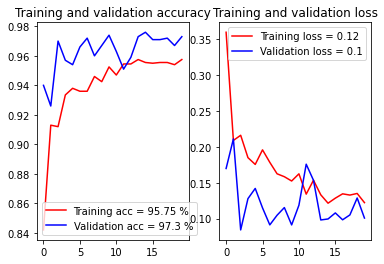

In [26]:
plot_acc_loss(TL_history.history)

รูปที่ 4.37 ค่าความแม่นยำและค่าสูญเสียจากโมเดลถ่ายโอนการเรียนรู้

เราสามารถทดสอบโดยใช้ภาพสุนัขและแมวของตัวเองได้โดยใส่ชื่อไฟล์ในโค้ดด้านล่างนี้ 

1/1 [==============================] - 0s 28ms/step
[0.]
fongbeer.jpg is a cat


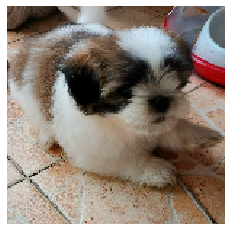

In [30]:
#from keras.preprocessing import image
fn = "fongbeer.jpg"
# predicting images
path='content/' + fn
img = tf.keras.utils.load_img(path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = TL_model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0:
    print(fn + " is a dog")
else:
    print(fn + " is a cat")

```{admonition} หมายเหตุ :
ในตัวอย่างนี้ต้องการแสดงการสร้างโมเดลเท่านั้น การพยากรณ์ไม่แม่นยำเนื่องจากฝึกเป็นจำนวนรอบน้อยและใช้ข้อมูลภาพไม่มาก
```

## 4.6 การประยุกต์ใช้งานด้านการตรวจหาวัตถุ

ที่ผ่านมาในบทนี้เราได้ศึกษาการใช้งานโมเดล CNN เพื่อจำแนกประเภทองค์ประกอบที่อยู่ในภาพ ในงานบางประเภทเช่นยานยนต์ที่ขับเคลื่อนอัตโนมัติ 
การจำแนกประเภทอย่างเดียวไม่เพียงพอ เรายังต้องการทราบตำแหน่งของวัตถุที่อยู่ในภาพด้วยเพื่อหลบหลีกมิให้เกิดการชนกับวัตถุนั้น 
เช่นเดียวกับการควบคุมแขนกลหรือหุ่นยนต์ให้เคลื่อนที่ไปยังตำแหน่งเป้าหมาย 

### 4.6.1 การจำแนกและระบุตำแหน่งวัตถุ

ก่อนที่จะไปถึง <em>การตรวจหาวัตถุ (object detection)</em> เราต้องทำความเข้าใจกับ <em>การระบุตำแหน่งวัตถุ (object localization)</em> เสียก่อน 
จากรูปที่ 4.38 จะเห็นว่านอกจากการจำแนกวัตถุว่าเป็นรถยนต์แล้ว เรายังต้องการทราบตำแหน่งของรถยนต์ในภาพโดยกำหนดพิกัดจุดกลาง 
$b_x, b_y$ และความกว้างและยาว $b_w, b_h$ ของกล่องสี่หลี่ยมล้อมรอบที่เป็นสีแดงในภาพ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1vqKCBIhrT5sA6I7FBG5o0gU0_79OEFFi" width=700 />
</p>
<p />
<div align="center">รูปที่ 4.38 การจำแนกและระบุตำแหน่งวัตถุ</div>

<div style=".noindent"><b>ตัวอย่าง 4.9</b></div>

สมมุติว่าเราต้องการสร้างโมเดลสำหรับจำแนกและระบุตำแหน่งของวัตถุในภาพ 4 ประเภทดังนี้


<ol>
<li />คนเดินเท้า
<li />รถยนต์
<li />รถจักรยานยนต์
<li />พื้นหลัง (ไม่มีวัตถุ 1-3 ในภาพ)
</ol>


```{admonition} หมายเหตุ : 
เพื่อความสะดวกในการเขียนขอใช้คำว่าวัตถุ (object) แทนองค์ประกอบในภาพที่เป็นเป้าหมายรวมถึงมนุษย์ด้วย
```

เพื่อทำให้ปัญหาง่ายขึ้นสำหรับการอธิบายตัวอย่างพื้นฐานนี้จะตั้งสมมุติฐานว่ามีวัตถุเพียงชนิดเดียวปรากฏในภาพ 
ในส่วนการนิยามเอาต์พุตและเลเบล จะเพิ่มจำนวนเอาต์พุตเพื่อระบุตำแหน่งของวัตถุ $b_x, b_y, b_w, b_h$ 
ดังนั้นสามารถกำหนดเอาต์พุตได้ดังในรูปที่ 4.39 โดยเอาต์พุตเป็นเวกเตอร์ขนาดความยาวเท่ากับ 8 

$$
y = \begin{bmatrix} y_1 & y_2 & \ldots & y_8 \end{bmatrix}^T
= \begin{bmatrix}
p_c & b_x & b_y & b_w & b_h & c_1 & c_2 & c_3
\end{bmatrix}^T \tag{4.7}
$$

สมาชิกแรก $p_c = 0$  แทนกรณี 4 คือไม่พบวัตถุในกลุ่มเป้าหมาย หรือ $p_c = 1$ 
คือเมื่อตรวจพบวัตถุในกลุ่ม 1 - 3 ในภาพ สำหรับสมาชิกที่ 2 - 5 ของเวกเตอร์คือพิกัดของกล่องที่ล้อมรอบวัตถุ คือพิกัดจุดกลาง 
$b_x, b_y$ และความกว้างและยาว $b_w, b_h$ จะได้กล่าวถึงการกำหนดค่าเหล่านี้ภายหลัง ส่วนสมาชิกที่ 6 - 8 
แทนประเภทของวัตถุที่ตรวจพบ สำหรับรถยนต์ในรูปที่ 4.37 จะได้ค่า $c_1 = 0, c_2 = 1, c_3 = 0$ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=193HOiCm-5GP5oOOC4GdSfx3NLoSidto0" width=700 />
</p>
<p />
<div align="center">รูปที่ 4.39 การนิยามเอาต์พุตและเลเบล</div>

สังเกตว่าสมาชิกแรก $p_c$ มีความสำคัญ เพราะหากไม่ตรวจพบวัตถุ $p_c = 0$ จะไม่ต้องสนใจค่าของสมาชิกที่เหลือทั้งหมด 

เมื่อกำหนดเอาต์พุตและเลเบลตาม (4.7) จะนิยามฟังก์ชันสูญเสียได้เป็น 2 กรณี คือ

$$
\mathcal{L}(\hat{y},y) = (\hat{y}_1 - y_1)^2 + (\hat{y}_2 - y_2)^2 + \ldots + (\hat{y}_8 - y_8)^2, \;\; y_1 = 1 \tag{4.8}
$$

$$
\mathcal{L}(\hat{y},y) = (\hat{y}_1 - y_1)^2 , \;\; y_1 = 0 \tag{4.9}
$$

หมายความว่าเมื่อตรวจพบวัตถุ ค่าสูญเสียจะเท่ากับค่าเฉลี่ยกำลังสองของค่าแตกต่าง (mse) ของแต่ละสมาชิกของ $y$ และ $\hat{y}$ ส่วนเมื่อไม่พบวัตถุ 
ค่าสมาชิกอื่นนอกจากสมาชิกแรกจะไม่มีความหมายใดๆ ดังนั้นค่าสูญเสียจึงเท่ากับค่าเฉลี่ยกำลังสองของค่าแตกต่างของ $y_1$ และ $\hat{y}_1$ เท่านั้น 

```{admonition} หมายเหตุ : 
ในตัวอย่างนี้ใช้ค่าสูญเสียแบบ mse กับทุกสมาชิกเพื่อให้ง่ายขึ้นเท่านั้น ในทางปฏิบัติอาจใช้การนิยามที่ซับซ้อนมากขึ้น 
เช่นใช้ฟังก์ชันสูญเสียควรจะเป็นแบบลอการิทึม (log likelihood) กับสมาชิก 6 - 8 และฟังก์ชันสูญเสียถดถอยลอจิสติกกับสมาชิก 1 
```

### 4.6.2 วิธีการหน้าต่างเลื่อน

การตรวจหาวัตถุในยุคเริ่มต้นของการเรียนรู้เชิงลึกใช้วิธีการที่เรียกว่า <em>หน้าต่างเลื่อน (sliding window)</em> ดังแสดงในรูปที่ 4.40 
เริ่มจากการฝึกโมเดลจากภาพที่ตัดส่วนให้พอดีกับวัตถุเป้าหมายแต่ละประเภท 
และในการใช้งานจะกำหนดขนาดของหน้าต่างที่จะเลื่อนไปบนภาพรวมเริ่มจากมุมบนซ้ายไปขวาและบนลงล่างตามช่วงก้าวที่กำหนด
ทิศทางการเลื่อนของหน้าต่างจะเป็นลักษณะเดียวกับการดำเนินการสังวัตนาการ สังเกตจากรูปที่ 4.40 
ว่าขนาดของหน้าต่างอาจไม่สัมพันธ์กับขนาดของวัตถุในภาพเสมอไป ดังนั้นจึงมีการแปรขนาดของหน้าต่างและเลื่อนซ้ำบนภาพ

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1pLf6aj--mX_mdz5v--CSfw-aC_jb7m5a" width=700 />
</p>
<p />
<div align="center">รูปที่ 4.40 การตรวจหาวัตถุโดยวิธีเลื่อนหน้าต่าง</div>

จากคำอธิบายเชื่อว่าผู้อ่านคงคาดเดาได้ถึงปัญหาของวิธีการหน้าต่างเลื่อน การดำเนินการดังกล่าวจะต้องใช้เวลาและการคำนวณค่อนข้างมากต่อหนึ่งภาพ 
ดังนั้นวิธีการนี้ใช้ได้ผลในระดับหนึ่งโดยพยายามลดความซับซ้อนในการคำนวณเช่นใช้ฟังก์ชันเชิงเส้นในการจำแนก 
อย่างไรก็ตามการใช้งานแบบเรียลไทม์ในทางปฏิบัติโดยทั่วไปต้องการวิธีการที่มีประสิทธิภาพมากกว่าวิธีการหน้าต่างเลื่อน 
ซึ่งต่อไปเราจะพบว่าขั้นตอนวิธีในการตรวจหาวัตถุสามารถทำได้ในครั้งเดียวต่อหนึ่งภาพโดยการดำเนินการสังวัตนาการ

### 4.6.3 การแปลงชั้นเชื่อมต่อเต็มเป็นชั้นสังวัตนาการ

ก่อนที่จะกล่าวถึงการอิมพลิเมนต์หน้าต่างเลื่อนเชิงสังวัตนาการ เราต้องเข้าใจเกี่ยวกับการแปลงชั้นเชื่อมต่อเต็มเป็นชั้นสังวัตนาการ 
เพราะในโมเดลที่จะใช้ต่อไปจะไม่มีชั้นเชื่อมต่อเต็มในส่วนท้ายก่อนชั้นเอาต์พุต 

ยกตัวอย่างโมเดล CNN ที่มีโครงสร้างดังในรูปที่ 4.41 ส่วนแรกคือชั้นสังวัตนาการร่วมกับการพูลลิงค่ามากสุด 
ซึ่งไม่ใช่ประเด็นสำคัญในบริบทนี้ เราต้องการเน้นเฉพาะส่วนท้ายที่มีชั้นเชื่อมต่อเต็ม (FC) 2 ชั้น 
แต่ละชั้นมีจำนวนเซลล์เท่ากับ 400 ก่อนจะถึงชั้นเอาต์พุตแบบซอฟต์แมกซ์ที่จำแนกเป็น 4 ประเภท 
เราต้องการเปลี่ยนชั้นในส่วนท้ายนี้ให้เป็นชั้นสังวัตนาการเพื่อรองรับการตรวจหาวัตถุในภาพที่จะกล่าวถึงต่อไป 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=142sTx7GvqAhgktCs0lOwi37U4rCBC07Q" width=700 />
</p>
<p />
<div align="center">รูปที่ 4.41 โมเดล CNN เดิมที่มีชั้นเชื่อมต่อเต็มก่อนถึงชั้นเอาต์พุต</div>

รูปที่ 4.42 แสดงโมเดลที่ชั้นเชื่อมต่อเต็มในส่วนท้ายถูกแปลงเป็นชั้นสังวัตนาการ เริ่มจากการใช้เคอร์เนลขนาด 5 x 5 x 16 จำนวน 400 ชุด 
ผลจากการทำสังวัตนาการจะได้เอาต์พุตขนาด 1 x 1 จำนวน 400 ช่อง ซึ่งมองได่้เป็นเวกเตอร์มิติเดียวขนาด 400 
สมาชิกเช่นเดียวกับการแผ่เทนเซอร์เป็นเวกเตอร์ในกรณีชั้นเชื่อมต่อเต็ม เพียงแต่จะผ่านการสังวัตนาการโดยเคอร์เนลที่พารามิเตอร์สามารถเรียนรู้ได้ 
เช่นเดียวกันกับชั้นเชื่อมต่อเต็มถัดมาถูกแทนที่โดยกาารทำสังวัตนาการกับเคอร์เนลขนาด 1 x 1 x 400 
จำนวน 400 ชุด ส่วนชั้นสุดท้ายถูกแทนที่โดยชั้นสังวัตนาการที่มีเคอร์เนลขนาด 1 x 1 x 400 จำนวน 4 ชุด ได้เอาต์พุตเป็นเทนเซอร์ขนาด 1 x 1 x 4 
ซึ่งเปรียบได้กับเวกเตอร์ที่มี 4 สมาชิกจากฟังก์ชันซอฟต์แมกซ์เดิม 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1bnOTPzml2JtYZJpwX5uhFNqJhK5xVgeg" width=700 />
</p>
<p />
<div align="center">รูปที่ 4.42 โมเดล CNN ที่ชั้นเชื่อมต่อเต็มถูกแปลงเป็นชั้นสังวัตนาการ</div>

มาถึงขั้นนี้ผู้อ่านคงสงสัยถึงประโยชน์ของโมเดล CNN รูปแบบใหม่ที่ดูเหมือนจะเพิ่มความซับซ้อนด้านการคำนวณมากขึ้นกว่าเดิม 
ซึ่งต่อไปเราจะอธิบายว่าโครงสร้างของการสังวัตนาการนี้เพิ่มประสิทธิภาพของการตรวจหาวัตถุเพราะไม่ต้องใช้วิธีการหน้าต่างเลื่อน 

### 4.6.4 อิมพลิเมนต์หน้าต่างเลื่อนโดยการสังวัตนาการ

หลังจากศึกษาการแปลงชั้นเชื่อมต่อเต็มเป็นชั้นสังวัตนาการแล้ว เราสามารถที่จะอิมพลิเมนต์หน้าต่างเลื่อนโดยโมเดลดังในรูปที่ 4.42 
โดยวิธีที่นำเสนอในบทความ {cite}`Sermanet_2014` สมมุติว่าอินพุตจากหน้าต่างเลื่อนที่เป็นแบบ RGB กำหนดไว้เท่ากับ 14 x 14 x 3 
โดยเราใช้หน้าต่างขนาดเล็กเพียงเพื่อให้ปัญหาง่ายขึ้นในการอธิบาย ดังนั้นการดำเนินการจะสมนัยกับรูปที่ 4.42 ได้เอาต์พุตเป็นเทนเซอร์ 
1 x 1 x 4 

ต่อมาสมมุติว่าภาพอินพุตทั้งหมดที่เราเลื่อนหน้าต่างผ่านมีขนาด 16 x 16 x 3 ต้องการเลื่อนหน้าต่างโดยใช้ช่วงก้าวเท่ากับ 2 
จะต้องเลื่อนหน้าต่างขนาด 14 x 14 x 3 จากซ้ายมาขวาและบนลงล่างเป็นจำนวนทั้งหมด 4 ครั้งและผ่านข้อมูลอินพุตแต่ละครั้งสู่โมเดลรูปที่ 
4.42 แต่เมื่อพิจารณาการคำนวณในแต่ละครั้งโดยละเอียดจะพบว่ามีความซ้ำซ้อนกันอย่างมาก 
เราสามารถขยายการสังวัตนาการเพื่อใช้การคำนวณร่วมกันทำให้ได้เอาต์พุตทั้งหมดในครั้งเดียวโดยไม่ต้องมีการเลื่อนหน้าต่างดังแสดงในรูปที่ 4.43
โดยอินพุตของโมเดลมีขนาด 16 x 16 x 3 เท่ากับขนาดภาพอินพุตรวม และเอาต์พุตเป็นเทนเซอร์ขนาด 2 x 2 x 4 
สังเกตเทนเซอร์ของเอาต์พุตที่สอดคล้องกับตำแหน่งที่เป็นไปได้ทั้งหมดของหน้าต่างเลื่อนซึ่งจะได้จากการสังวัตนาการเพียงครั้งเดียว 
เราสามารถขยายหลักการนี้ไปยังขนาดหน้าต่างเลื่อนและภาพของอินพุตที่ใช้งานจริงโดยเลือกขนาดของเคอร์เนลและจำนวนชุดที่เหมาะสม 
จนกระทั่งได้เทนเซอร์เอาต์พุตที่มีขนาดของแต่ละมิติตามต้องการ

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1aZ1hpFMA3_0tblTcBo-FRroVpGyJEi5o" width=650 />
</p>
<p />
<div align="center">รูปที่ 4.43 โมเดลสังวัตนาการที่ใช้แทนการเลื่อนหน้าต่าง</div>




## 4.7 ขั้นตอนวิธี YOLO

YOLO ย่อมาจาก "You Only Look Once" {cite}`Yolo_2016` อธิบายโดยรวมคือการประมวลผลเพื่อตรวจหาวัตถุสำหรับทั้งภาพสามารถทำได้ภายในครั้งเดียว 
แตกต่างจากวิธีการเลื่อนหน้าต่างที่ต้องมีการกวาดหน้าต่างขนาดเล็กกว่าภาพตามช่วงก้าวที่กำหนด 
ดังนั้นจึงเพิ่มประสิทธิภาพและความเร็วในการคำนวณทำให้สามารถใช้งานในแบบเรียลไทม์ เช่นใช้ในยานยนต์ไร้คนขับ

ปัญหาหนึ่งของวิธีการเลื่อนหน้าต่างคือเป็นไปได้ยากที่จะมีขนาดพอดีกับกรอบที่เป็นขอบเขตล้อมรอบวัตถุซึ่งไม่จำเป็นต้องเป็นสี่เหลี่ยมจัตุรัส 
ดังนั้นประเด็นแรกของ YOLO คือทำอย่างไรจะกำหนดกรอบล้อมวัตถุได้อย่างแม่นยำ ขั้นแรกของขั้นตอนวิธี YOLO คือกำหนดกริด (grid) 
ให้กับภาพดังเช่นในรูปที่ 4.44 เพื่อความง่ายในการอธิบายกำหนดเป็น 3 x 3 แต่ในทางปฏิบัติควรใช้กริดที่ละเอียดขึ้นเช่น 19 x 19 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=10GeT19dSibO_IwrjsaLbFba3-5IBrMoM" width=600 />
</p>
<p />
<div align="center">รูปที่ 4.44 การกำหนดกริดเพื่อตรวจหาวัตถุในขั้นตอนวิธี YOLO</div>

แนวคิดพื้นฐานคือประยุกต์การระบุตำแหน่งที่ได้อธิบายข้างต้นกับแต่ละกริดในภาพ โดยนิยามเลเบล $\hat{y}$ ตาม (4.7) และตรวจหาวัตถุในกลุ่มเป้าหมาย 
ในที่นี้จะเรียกตำแหน่งกริดเช่นเดียวกับสมาชิกของเมทริกซ์ขนาด 3 x 3 ดังนั้นสำหรับกริดตำแหน่ง (1,1),(1,2),(1,3),(3,1),(3,2),(3,3) 
ที่ไม่พบวัตถุ จะได้ค่า $p_c = 0$ และไม่สนใจสมาชิกที่เหลือของ $\hat{y}$ ส่วนกริด (2,1) ตรวจพบรถยนต์ที่ทั้งคันอยู่ภายในกริด 
ที่เป็นปัญหาคือรถยนต์ทางด้านขวาควรถูกกำหนดให้กริด (2,2) หรือ (2,3) ? ขั้นตอนวิธี YOLO จะพิจารณาค่าของ $b_x, b_y$ คือจุดกึ่งกลางของวัตถุ 
หากอยู่ในกริดใดจะกำหนดวัตถุให้กริดนั้น เนื่องจากพบว่าจุดกึ่งกลางของรถยนต์ด้านขวาอยู่ในพื้นที่กริด (2,3) ดังนั้นจึงกำหนดให้กริด (2,3) เป็นเจ้าของวัตถุ

คำตามต่อมาคือจะกำหนดค่าให้กับจุดกลาง $b_x, b_y$ และขนาดของกรอบ $b_w, b_h$ อย่างไร วิธีการคือให้ค่ามุมบนซ้ายของกริดมีค่า (0,0) 
และมุมล่างขวาเท่ากับ (1,1) ดังนั้นค่าจุดกลาง $b_x, b_y$ จึงเป็นอัตราส่วนที่สัมพันธ์กับตำแหน่งของจุด และสังเกตว่า $b_x \le 1, b_y \le 1$ 
เพราะจุดกึ่งกลางจะต้องอยู่ในกริดที่มอบหมายให้กับวัตถุนั้นเสมอ สำหรับค่าความกว้าง $b_w$ และความสูง $b_h$ 
คืออัตราส่วนของขนาดเมื่อเทียบกับความกว้างและความสูงของกริด ซึ่งทั้งสองสามารถมีค่ามากกว่าหนึ่งได้ในกรณีที่กรอบล้ำออกไปจากกริดมาก 
โดยวิธีการกำหนดค่านี้ เลเบลของกริด (3,1) และ (3,3) กำหนดได้เป็นดังนี้ (ค่าประมาณด้วยสายตาเพื่อการอธิบาย
ในการกำหนดเลเบลจริงต้องวัดให้แม่นยำกว่านี้)
  
$$
y = \begin{bmatrix} 1 & 0.4 & 0.35 & 0.55 & 0.3 & 0 & 1 & 0 \end{bmatrix}^T \tag{4.10}
$$

$$
y = \begin{bmatrix} 1 & 0.1 & 0.5 & 1.5 & 0.8 & 0 & 1 & 0 \end{bmatrix}^T \tag{4.11}
$$

ในงานวิจัยที่ต่อยอดจาก YOLO มีการปรับปรุงการเรียนรู้ค่าพารามิเตอร์เหล่านี้ให้ทำงานดีขึ้น เช่นการใช้ฟังก์ชันซิกมอยด์เพื่อทำให้ $b_x \le 1, b_y \le 1$ 
หรือใช้เลขชี้กำลังเพื่อให้มั่นใจว่าพารามิเตอร์ของกล่องไม่เป็นค่าลบ 

### 4.7.1 อัตราส่วนอินเตอร์เซกชันต่อยูเนียน

เราจะทราบอย่างไรว่าขั้นตอนวิธีการตรวจหาวัตถุทำงานได้ดีหรือไม่ ดัชนีหนึ่งที่ใช้เรียกว่า 
<em>อัตราส่วนอินเตอร์เซกชันต่อยูเนียน (intersection over union) </em> 
หรือเรียกโดยย่อว่า $IOU$ ตัวอย่างเช่นต้องการตรวจหารถยนต์ในรูปที่ 4.45 กล่องที่ถูกต้องที่เป็นเลเบลคือสีแดงที่ล้อมรอบตัวรถพอดี 
แต่สมมุติว่ากล่องที่โมเดลพยากรณ์คือสีน้ำเงินที่เยื้องไปทางด้านบนซ้ายของภาพ ให้ค่าอินเตอร์เซกชันแทนด้วย $I$ 
คือพื้่นที่ส่วนร่วมของกล่องสี่เหลี่ยมทั้งสอง (สี่เหลี่ยมเล็กส่วนกลางที่กล่องทั้งสองตัดกัน) 
และค่ายูเนียนแทนด้วย $U$ คือพื้นที่ส่วนรวมของกล่องทั้งสอง ดังนั้นค่า $IOU$ คำนวณได้จาก

$$
IOU = \frac{I}{U} \tag{4.12}
$$

ซึ่งจะได้ว่าค่า $IOU \le 1$ เสมอ โดยทั่วไปในงานรับรู้ภาพโดยคอมพิวเตอร์มักตัดสินว่าคำตอบถูกต้องเมื่อค่า $IOU \ge 0.5$ 
แต่หากต้องการความแม่นยำสูงขึ้นอาจกำหนดค่าที่สูงกว่านี้ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1abajmD6d1pFeonhEO5OF8BZSihmb9_go" width=500 />
</p>
<p />
<div align="center">รูปที่ 4.45 อัตราส่วนอินเตอร์เซกชันต่อยูเนียน (IOU)</div>

### 4.7.2 การขจัดการตรวจพบที่ไม่ใช่ค่ามากสุด

ปัญหาหนึ่งของการตรวจหาวัตถุคือ เมื่อภาพถูกแบ่งเป็นกริดย่อยที่มีความละเอียดเช่น 19 x 19 ขั้นตอนวิธีอาจพบวัตถุเดียวกันเป็นจำนวนหลายครั้ง 
ทั้งนี้เนื่องจากหลายกริดที่ใกล้เคียงกับศูนย์กลางของวัตถุอาจติดสินว่าเป็นกริดเจ้าของวัตถุนั้น 
<em>การขจัดค่าที่ไม่ใช่มากสุด (non-max suppression)</em> คือวิธีการหนึ่งที่ช่วยให้แน่ใจว่าแต่ละวัตถุถูกตรวจพบเพียงครั้งเดียว 

รูปที่ 4.46 แสดงการตรวจพบแต่ละวัตถุมากกว่าหนึ่งครั้ง โดยแต่ละค่าของเอาต์พุตจากการพยากรณ์จะมีค่า $p_c$ ดังในสมการ (4.7) 
ซึ่งเป็นตัวบ่งบอกความน่าจะเป็นว่ามีวัตถุในกริด การขจัดค่าที่ไม่ใช่มากสุดจะเลือกเฉพาะการพยากรณ์ที่มีค่า $p_c$ สูงสุดเท่านั้น และตัดตัวเลือกอื่นทิ้งไป 
<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=10QQ1KrWOS_R9NSep0oPMoufoeERQFyPA" width=500 />
</p>
<p />
<div align="center">รูปที่ 4.46 การขจัดการตรวจพบที่ไม่ใช่ค่ามากสุด</div>

การอิมพลิเมนต์ขั้นตอนวิธีเป็นดังนี้

1.-ไม่พิจารณากล่องที่มีค่า $p_c \le 0.6$ โดยถือว่ามีความน่าจะเป็นของการพบวัตถุต่ำเกินไป

2.-สำหรับกล่องที่ยังเหลือ

&emsp; 2.1-เลือกกล่องที่มีค่า $p_c$ มากที่สุดเป็นเอาต์พุตการพยากรณ์

&emsp; 2.2-ขจัดกล่องอื่นใดที่มีค่า $IOU \ge 0.5$ กับกล่องที่เลือกในขั้นตอน 2.1



### 4.7.3 กล่องจุดตรึง 

ปัญหาอีกประการหนึ่งของวิธีการตรวจหาวัตถุที่กล่าวถึงมาจนถึงจุดนี้คือ ในแต่ละกริดสามารถตรวจพบวัตถุได้เพียงหนึ่งกล่องเท่านั้น 
<em>กล่องจุดตรึง (anchor box)</em> เป็นวิธีการหนึ่งที่ช่วยขยายให้หนึ่งกริดสามารถมีวัตถุหลายกล่องได้ ตัวอย่างเช่นภาพในรูปที่ 4.47 
เพื่อให้เข้าใจได้ง่ายจะแบ่งกริดเป็นเพียง 3 x 3 
จะเห็นว่าจุดกึ่งกลางของกล่องที่ล้อมรอบบุคคลและรถยนต์อยู่ในกริดเดียวกันคือกริดที่อยู่กึ่งกลางภาพ ซึ่งเลเบลที่นิยามตามสมการ (4.7) 
ไม่สามารถครอบคลุมกล่องทั้งสองพร้อมกันได้ จำเป็นต้องเลือกเอากล่องใดกล่องหนึ่ง

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1xjgCPacsz0VEDCQX-HNehZ3UCcspTKGm" width=500 />
</p>
<p />
<div align="center">รูปที่ 4.47 วิธีการกล่องจุดตรึง</div>

แนวคิดของวิธีกล่องจุดตรึงคือนิยามกล่องที่มีรูปร่างต่างกันไว้ก่อน เช่น กล่องจุดตรึงหมายเลข 1 มีลักษณะเป็นสี่เหลี่ยมทรงสูงสำหรับบุคคลในท่ายืน 
และกล่องจุดตรึงหมายเลข 2 เป็นสี่เหลี่ยมผืนผ้าในแนวนอนสำหรับรถยนต์ ดังนั้นเราสามารถเชื่อมโยงการพยากรณ์ 2 ครั้งเข้ากับรูปทรงของกล่องจุดตรึงได้ 
ในกรณีทั่วไปเราสามารถนิยามกล่องจุดตรึงหลายกล่องเช่น 5 หรือมากกว่านั้น แต่ในที่นี้จะนิยามเพียง 2 เพื่อความง่ายในการอธิบาย 
ในกรณีนี้เลเบลจะถูกขยายเป็นสองเท่า (จากเวกเตอร์ความยาว 8 เป็น 16) เพื่อรองรับกล่องจุดตรึงทั้งสองเป็นดังนี้

$$
y =  \begin{bmatrix}
p_{c1} & b_{x1} & b_{y1} & b_{w1} & b_{h1} & c_{11} & c_{12} & c_{13} & p_{c2} & b_{x2} & b_{y2} & b_{w2} & b_{h2} & c_{21} & c_{22} & c_{23}
\end{bmatrix}^T \tag{4.13}
$$

โดยสมาชิก 8 ค่าชุดแรกและชุดที่สองสำหรับกล่องจุดตรึง 1 และ 2 ตามลำดับ เมื่อโมเดลพยากรณ์พบกล่องวัตถุที่มีจุดกึ่งกลางในกริดก็จะกำหนดกล่องให้กับกริดนั้น 
และเลือกกล่องจุดตรึงที่ให้ค่า IOU กับกล่องวัตถุสูงสุด เช่นสำหรับบุคคลในท่ายืน กล่องจุดตรึงที่เป็นสี่เหลี่ยมทรงสูงจะให้ค่า IOU สูงกว่ากล่องในแนวนอน 

รูปที่ 4.48 แสดงตัวอย่างเป็นรูปธรรมจากการใช้กล่องจุดตรึง 2 รูปทรง เมื่อตรวจพบบุคคลและรถยนต์ในกริดเดียวกัน เวกเตอร์เอาต์พุตจะได้ตามด้านบนคือ 
กล่องสำหรับบุคคลจะถูกกำหนดให้กับ 8 สมาชิกแรก และสำหรับรถยนต์ให้กับ 8 สมาชิกหลัง ส่วนในกรณีที่พบรถยนต์เป็นวัตถุเดียวในกริด 
เวกเตอร์เอาต์พุตในส่วนกล่องจุดตรึงแรกจะได้ค่า $p_{c1} = 0$ ทำให้ไม่ต้องสนใจสมาชิก 7 ค่าที่เหลือ ส่วนสมาชิกอีก 8 
ตัวหลังสำหรับกล่องจุดตรึงที่สองที่ตรวจพบรถยนต์จะได้ค่าพิกัดและขนาดของกล่องและประเภทสอดคล้องกับรถยนต์ในกริดนั้น 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1BLUEeSw9KB0jfWp_vGb_6eRq4b7Lx6MG" width=500 />
</p>
<p />
<div align="center">รูปที่ 4.48 เอาต์พุตจากวิธีกล่องจุดตรึง</div>

ข้อจำกัดของวิธีการกล่องจุดตรึงคือไม่สามารถตรวจหาวัตถุได้ถูกต้องกรณีที่มีจำนวนวัตถุในกริดเดียวกันมากกว่าจำนวนกล่องจุดตรึง 
หรือในกริดเดียวกันมีวัตถุที่ตรงกับกล่องจุดตรึงรูปแบบเดียวกันมากกว่าหนึ่ง 
อย่างไรก็ตามกรณีดังกล่าวเกิดขึ้นไม่บ่อย โดยเฉพาะเมื่อแบ่งกริดให้มีความละเอียดมากขึ้น 
หากต้องการแก้ไขให้ครอบคลุมต้องเพิ่มเติมฟังก์ชันพิเศษในขั้นตอนวิธีเพื่อเลือกเฉพาะวัตถุที่สำคัญกว่า 
เช่นหากมีรถยนต์ซ้อนกันให้เลือกรถยนต์คันที่อยู่ใกล้สุด

สรุปการใช้งานขั้นตอนวิธี YOLO พื้นฐานคือ ในขั้นตอนการฝึกใช้ข้อมูลภาพที่มีความหลากหลายของพื้นหลังและวัตถุกลุ่มเป้าหมาย 
มีจำนวนภาพมากเพียงพอ และสร้างเลเบลสำหรับแต่ละภาพเป็นเวกเตอร์ดังเช่นในสมการ (4.7),(4.13) 
หรือมีสมาชิกมากขึ้นตามประเภทของวัตถุและประเภทของวัตถุเป้าหมาย ค่าต่างๆ เช่นขนาดและตำแหน่งกรอบถูกระบุอย่างแม่นยำ
รวมถึงความน่าจะเป็นที่ตรวจพบวัตถุในแต่ละประเภท (เป็นค่าตรรกะ 0 หรือ 1) 
เวลาในการฝึกขึ้นกับจำนวนข้อมูล ความซับซ้อนของโมเดล 
และสมรรถนะของคอมพิวเตอร์ที่ใช้ หลังการฝึกแล้วจึงนำโมเดลมาพยากรณ์เพื่อดูความแม่นยำ 
สังเกตว่าเอาต์พุตจากการพยากรณ์ในขั้นต้นจะมีค่าในทุกสมาชิกของเวกเตอร์ ซึ่งอาจไม่ใช่วัตถุแต่เป็นเพียงการรบกวน 
กล่าวคือในกรณีใช้กล่องจุดตรึง 2 กล่อง แต่ละกริดจะให้เอาต์พุตเป็นกล่องจำนวน 2 
กล่องที่อยู่ตำแหน่งใดก็ได้ในภาพและอาจไม่มีวัตถุใดๆ ในกล่อง  (คือ $p_{c1}, p_{c2} $ มีค่าน้อย)
ดังนั้นในขั้นแรกคือขจัดการพยากรณ์ที่มีความน่าจะเป็นต่ำ เช่น $p_{cn} \le 0.6, \;n = 1,2$ ทิ้งไปเสียก่อน 
สำหรับกล่องที่เหลือในแต่ละประเภท ใช้การขจัดค่าที่ไม่ใช่มากสุดเพื่อเลือกกล่องที่เป็นเอาต์พุตการพยากรณ์ขั้นสุดท้าย 
หากใช้ข้อมูลทดสอบกับโมเดลและยังไม่พอพอใจในผลการพยากรณ์ อาจปรับแต่งไฮเปอร์พารามิเตอร์ของโมเดล 
ปรับปรุงข้อมูลฝึกแล้วทำการฝึกใหม่ เมื่อพอใจในความแม่นยำแล้วจึงนำไปใช้งานจริง

สำหรับผู้ที่ไม่มีทรัพยากรเพียงพอในการฝึกโมเดลสำหรับ YOLO เอง สามารถดาวน์โหลดโมเดลที่ผ่านการฝึกแล้วจากอินเทอร์เน็ต 
อย่างไรก็ตามพบว่ามีหลายเวอร์ชันและมีการพัฒนาอย่างต่อเนื่องแม้ในขณะที่เขียนหนังสือนี้ 


## 4.8 การประยุกต์ใช้งานด้านการรู้จำใบหน้า

<em>การรู้จำใบหน้า (face recognition)</em> เป็นงานอีกประเภทหนึ่งที่สามารถนำโมเดล CNN มาใช้ได้อย่างมีประสิทธิภาพ ซึ่งปัจจุบันมีการใช้อย่างแพร่หลาย 
เช่นในระบบรักษาความปลอดภัยของอาคารที่จะตรวจภาพใบหน้าของบุคคล ณ ทางเข้าอาคารว่าใช่บุคลากรที่มีสิทธิ์ผ่านเข้าออกหรือไม่ 
สำหรับการตรวจขั้นสูงอาจมีการเพิ่มฟังก์ชันว่าเป็นภาพของบุคคลที่อยู่ในสถานที่จริงมีการเคลื่อนไหว มิใช่การนำภาพนิ่งของบุคคลนั้นมาเพื่อหลอกระบบ 
ในหัวข้อนี้จะกล่าวถึงเฉพาะพื้นฐานของการรู้จำใบหน้า โดยเริ่มจากความแตกต่างของศัพทวิทยาระหว่างการรู้จำใบหน้ากับ <em>การทวนสอบใบหน้า 
(face verification)</em> ซึ่งเป็นปัญหาที่ง่ายกว่า 

ในโจทย์ปัญหาของการทวนสอบใบหน้า อินพุตของระบบคือภาพของบุคคลที่ต้องการทวนสอบ และชื่อหรือข้อมูลเฉพาะของบุคคลนั้น 
เช่นเลขบัตรประชาชนหรือหมายเลขพนักงาน  หลังจากผ่านการทวนสอบแล้ว เอาต์พุตคือการยืนยันหรือปฏิเสธว่าเป็นภาพของบุคคลที่ตรงกับข้อมูลระบุ 
ดังนั้นปัญหานี้จึงมีลักษณะ 1:1 แต่สำหรับปัญหาการรู้จำใบหน้าจะมีลักษณะ 1:K กล่าวคือ ภาพที่เป็นอินพุต ณ เวลานั้นจะถูกตรวจสอบกับฐานข้อมูลจำนวน K บุคคล 
เอาต์พุตของระบบคือการยืนยันว่าภาพเป็นหนึ่งในบุคลากรจำนวน K นั้นหรือไม่ จะเห็นได้ว่าปัญหาการรู้จำใบหน้าจะมีความยากกว่าการทวนสอบใบหน้ามาก 
ตัวอย่างเช่นสมมุติว่าเราได้ความแม่นยำจากการทวนสอบ 99 % ซึ่งโดยทั่วไปเรียกได้ว่าเป็นสมรรถนะที่ยอมรับได้ แต่สำหรับการรู้จำใบหน้าที่มีบุคลากรในฐานข้อมูล 
100 คน ความแม่นยำ 99% หมายความว่ามีโอกาสพยากรณ์ผิด 1 ใน 100 คน ซึ่งเราคงไม่อยากเป็นคนๆ นั้นที่ระบบรู้จำผิดพลาด 
ในปัญหาการรู้จำใบหน้าอาจต้องการความแม่นยำที่สูงมากเช่น 99.9 % หรือสูงกว่านั้น

ในการศึกษาเราจะเริ่มจากการกล่าวถึงอุปสรรคสำคัญ คือหาคำตอบจากข้อมูลเพียงภาพเดียว (one-shot problem) 

### 4.8.1 การเรียนรู้จากภาพเดียว

ในงานการรู้จำใบหน้าทั่วไป โมเดลต้องเรียนรู้จากข้อมูลภาพเพียงภาพเดียวของแต่ละบุคคล ซึ่งปกติแล้วขั้นตอนวิธีการเรียนรู้เชิงลึกไม่สามารถทำงานได้ดีภายใต้ข้อมูลน้อย 
ตัวอย่างเช่นในรูปที่ 4.49 สมมุติว่าแผนกขนาดเล็กในองค์กรแห่งหนึ่งต้องการสร้างระบบเปิดประตูห้องทำงานรวมจากภาพใบหน้า โดยภาพด้านบนคือฐานข้อมูลของรูปบุคลากร
4 คนในแผนกซึ่งมีเพียง 1 ภาพสำหรับแต่ละบุคคล เมื่อกล้องหน้าประตูถ่ายภาพบุคคลที่ต้องการเข้าห้องและเปรียบเทียบกับภาพใบหน้าในฐานข้อมูล 
หากพยากรณ์ว่าเป็นภาพของ 1 ในบุคลากร 4 คนก็จะเปิดประตูให้เข้าห้องได้ แต่ถ้าไม่ใช่ก็จะไม่เปิด 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1HjW81S7ILMkImjLgK3zazX9poHoTgB6v" width=600 />
</p>
<p />
<div align="center">รูปที่ 4.49 การเรียนรู้จากภาพเดียว</div>

หากใช้วิธีการพื้นฐานที่ได้ศึกษามาในบทนี้ คือป้อนอินพุตภาพบุคลากรจากฐานข้อมูลผ่านโมเดล CNN ที่มีเอาต์พุตเป็นซอฟต์แมกซ์สำหรับการจำแนก 5 ประเภท 
(คือ 4 บุคคลในแผนก + 1 ไม่ใช่) แต่วิธีการนี้ไม่ได้ผลดีเนื่องจากมีข้อมูลฝึกน้อยเกินไป นอกจากนั้นการขยายระบบเมื่อมีจำนวนบุคลากรในแผนกมากขึ้นกระทำได้ยาก 
เพราะต้องเปลี่ยนจำนวนเอาต์พุตและฝึกโมเดลใหม่ทุกครั้งของการเปลี่ยนแปลง สรุปคือไม่ใช่แนวทางที่ดี

วิธีการที่เหมาะสมกว่าคือการเรียนรู้ <em>ฟังก์ชันความคล้าย (similarity function)</em> นิยาม $d(x_1,x_2)$ แทนระดับขั้นความแตกต่างระหว่างภาพ $x_1, x_2$ 
ดังนั้นต้องการให้ฟังก์ชันมีค่าน้อยเมื่อภาพที่เปรียบเทียบกันเป็นบุคคลเดียวกัน และมีค่ามากเมื่อไม่ใช่ ดังนั้นอาจตั้งค่าขีดแบ่ง (threshold) ไว้ที่ $\tau$ 
และประเมินว่าหาก $d(x_1,x_2) \le \tau$ บุคคลในภาพเป็นคนเดียวกัน รูปที่ 4.50 แสดงตัวอย่างการใช้งานกับโจทย์ปัญหาเดิมที่มีบุคลากร 4 คน 
มีเพียงภาพที่พยากรณ์ว่าเป็นบุคคลเดียวกันที่ฟังก์ชันความคล้ายให้ค่าน้อยคือ 0.1 สังเกตว่าวิธีการนี้ยังทำงานได้ดีเมื่อมีการเพิ่มจำนวนบุคลากรในฐานข้อมูล 
ซึ่งต่อไปเราจะลงรายละเอียดในการเรียนรู้ฟังก์ชันความคล้าย

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=19nvTecoOTwILeU6iKmnZIWuL6XjoTsg7" width=600 />
</p>
<p />
<div align="center">รูปที่ 4.50 การเรียนรู้ฟังก์ชันความคล้าย</div>

### 4.8.2 โครงข่ายสยาม 

การเรียนรู้ความคล้ายระหว่างภาพใช้โมเดลที่มีชื่อเรียกว่า <em>โครงข่ายสยาม (Siamese network)</em> {cite}`DeepFace_2014` 
คาดว่าได้ชื่อมาจากแฝดสยามที่เป็นที่รู้จักทั่วโลก 
รูปที่ 4.51 แสดงการใช้งานโครงข่ายสยาม จากตัวอย่างภาพแรกคือ $x^{(1)}$ เมื่อผ่านโมเดล CNN 
ที่ประกอบด้วยชั้นสังวัตนาการ ชั้นพูลลิง และชั้นเชื่อมต่อเต็มจนถึงเอาต์พุต แต่แทนที่จะใช้ซอฟต์แมกซ์ในการจำแนกประเภท 
เราจะพิจารณาเวกเตอร์ที่เป็นเอาต์พุตของชั้นสุดท้าย (ในภาพกำหนดขนาดเท่ากับ 128 เพื่อให้เป็นรูปธรรม) นิยามฟังก์ชันที่เอาต์พุตเป็น $f(x^{(1)})$ 
ที่เปรียบได้กับการเข้ารหัสตัวอย่างภาพ $x^{(1)}$ เป็นเวกเตอร์ขนาด 128 ดังนั้นสมมุติว่าเราต้องการเปรียบเทียบภาพนี้กับตัวอย่างภาพที่สอง 
$x^{(2)}$ ทำได้โดยอินพุตภาพที่สองผ่านโมเดลเดียวกันนี้ทำให้ได้เอาต์พุตการเข้ารหัสเป็น $f(x^{(2)})$ นิยามความแตกต่างระหว่างสองตัวออย่างนี้คือ
$$
d(x^{(1)},x^{(2)}) = \Vert f(x^{(1)}) - f(x^{(2)})\Vert_2^2 \tag{4.14}
$$

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1pHiXKg0n67rsDXCvmY5ZB2ByujpA0W7o" width=600 />
</p>
<p />
<div align="center">รูปที่ 4.51 การเรียนรู้ฟังก์ชันความคล้ายโดยโครงข่ายสยาม</div>

ในการฝึกโครงข่ายสยาม เริ่มต้นจากพิจารณาว่าเมื่อให้อินพุตเป็นตัวอย่างภาพ $x^{(i)}$ พารามิเตอร์ของโมเดลจะให้เอาต์พุตเป็นการเข้่ารหัส 
$f(x^{(i)})$ ดังนั้นเป้าหมายของการฝึกคือหากภาพสองตัวอย่าง  $x^{(i)}$, $x^{(j)}$ เป็นภาพของบุคคลเดียวกัน 
ต้องการให้ $d(x^{(i)},x^{(j)})$ มีค่าน้อย แต่หากไม่ใช่บุคคลเดียวกัน $d(x^{(i)},x^{(j)})$ ต้องมีค่ามาก 
เราต้องนิยามฟังก์ชันวัตถุประสงค์เพื่อให้ได้ผลตามนี้โดยใช้่ <em>ค่าสูญเสียชุดสาม (triplet loss)</em> {cite}`FaceNet_2015`

วิธีการของค่าสูญเสียชุดสามแสดงได้ดังรูปที่ 4.52 คือจะพิจารณาภาพ 3 ตัวอย่างในหนึ่งครั้ง โดยมีภาพที่เรียกว่า <em>ภาพตรึง (anchor)</em>
เป็นภาพของบุคคลที่เป็นเป้าหมายหลัก <em>ภาพบวก (positive)</em> คือภาพที่แตกต่างของบุคคลเดียวกัน 
และ <em>ภาพลบ (negative)</em> คือภาพบุคคลอื่น จะใช้อักษรย่อ A, P, N แทนภาพตรึง ภาพบวก 
และภาพลบตามลำดับ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1j-1-36a9VrG5t_Z4ONv2c1UvUS37WxTs" width=600 />
</p>
<p />
<div align="center">รูปที่ 4.52 ค่าสูญเสียชุดสาม</div>

ดังนั้นเป้าหมายของการฝึกคือต้องการให้

$$
d(A,P) = \Vert f(A) - f(P)\Vert_2^2 \le d(A,N) = \Vert f(A) - f(N)\Vert_2^2 \tag{4.15}
$$

กล่าวคือ

$$
\Vert f(A) - f(P)\Vert_2^2 - \Vert f(A) - f(N)\Vert_2^2 \le 0 \tag{4.16}
$$

เพื่อหลีกเลี่ยงกรณีผลเฉลยชัด (trivial solution) คือเมื่อ $d(A,P) = d(A,N) = 0$ ในทางปฏิบัติจะปรับ (4.16) เป็นดังนี้

$$
\Vert f(A) - f(P)\Vert_2^2 - \Vert f(A) - f(N)\Vert_2^2 + \alpha \le 0 \tag{4.17}
$$

โดย $\alpha$ เรียกว่าค่าเผื่อ (margin) เป็นไฮเปอร์พารามิเตอร์อีกตัวหนึ่งที่ปรับโดยผู้พัฒนา ดังนั้นเมื่อกำหนดภาพ 3 ตัวอย่างคือ A, P, N หนึ่งชุด
ตามคุณสมบัติที่อธิบายข้างต้น นิยามฟังก์ชันสูญเสียชุดสาม

$$
\mathcal{L}(A,P,N) = max(\Vert f(A) - f(P)\Vert_2^2 - \Vert f(A) - f(N)\Vert_2^2 + \alpha, 0) \tag{4.18}
$$

ซึ่งต้องการทำให้ฟังก์ชันนี้มีค่าน้อยสุด ดังนั้นฟังก์ชันมูลค่ารวมจะได้ไเป็น

$$
\mathcal{J} = \sum_{i=1}^m \mathcal{L}(A^{(i)}, P^{(i)}, N^{(i)}) \tag{4.19}
$$

ดังนั้นภาพที่ใช้ในการฝึกจะต้องมีภาพของแต่ละบุคคลมากกว่าหนึ่งภาพ ตัวอย่างเช่นหากต้องการฝึกโมเดลสำหรับบุคคล 1,000 คน โดยใช้ภาพของแต่ละบุคคลจำนวน 
10 ภาพ ดังนั้นจะต้องใช้ภาพในการฝึกทั้งหมด 10,000 ภาพ ซึ่งเราจะต้องจัดภาพเหล่านี้ให้เป็นชุดสามตามที่กำหนด คือ $A^{(i)}, P^{(i)}$ 
คือภาพบุคคลเดียวกัน และ $A^{(i)}, N^{(i)}$ คือภาพต่างบุคคล

สิ่งที่ต้องคำนึงในการจัดภาพให้เป็นชุดสามคือ หากเราเลือกภาพแบบสุ่ม อาจทำให้ได้สอดคล้องกับเงื่อนไข $d(A,P) + \alpha \le d(A,N)$ โดยง่ายเกินไป 
โดยเฉพาะเมื่อภาพ $A$ และ $N$ มีความแตกต่างอย่างเด่นชัด เช่นต่างเพศหรือต่างวัย ดังนั้นเราควรจัดชุดสามให้มีความยากในการฝึก 
กล่าวคือ $d(A,P) \approx d(A,N)$ รูปที่ 4.53 แสดงตัวอย่างการฝึกโมเดลโดยใช้ชุดสาม ในโมเดลที่ใช้งานจริงมักมีการฝึกโดยใช้ข้อมูลภาพจำนวนมาก
โดยอาจมีจำนวนเป็นล้าน สิบล้านหรือร้อยล้านภาพ ซึ่งบางบริษัทได้มอบโมเดลที่ทำการฝึกแล้วนี้ให้สังคมออนไลน์ได้ใช้ประโยชน์ 
ดังนั้นเราสามารถนำโมเดลมาประยุกต์ใช้ได้โดยผ่านการถ่ายโอนการเรียนรู้
<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1ZL7nh5n8SrDGQIGCcxI752bbvS7pvHQF" width=500 />
</p>
<p />
<div align="center">รูปที่ 4.53 การฝึกโมเดลโดยใช้ชุดสาม</div>

นอกเหนือจากการฝึกโดยชุดสามที่กล่าวถึงแล้ว อีกแนวทางหนึ่งในการทวนสอบใบหน้าคือใช้การจำแนกทวิภาคดังแสดงในรูปที่ 4.54 
โดยใช้โครงข่ายสยามในการเรียนรู้ภำาพ และในขั้นสุดท้ายใช้การถดถอยลอจิสติกในการพยากรณ์เอาต์พุต คือให้เอาต์พุตมีค่า 1 
เมื่อเป็นบุคคลเดียวกัน และ 0 หากเป็นต่างบุคคล 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1G0fMWoMgkPGwcEeF13zr0ooxCNEOy12n" width=600 />
</p>
<p />
<div align="center">รูปที่ 4.54 การเรียนรู้ฟังก์ชันความคล้ายโดยใช้่โมเดลจำแนกทวิภาค</div>

สมมุติว่าจำนวนเซลล์ในชั้นเชื่อมต่อเต็มสุดท้ายเท่ากับ 128 ค่าเอาต์พุตคำนวณได้จาก

$$
\hat{y} = \sigma \left(\sum_{k=1}^{128} w_i \lvert f(x^{(i)})_k - f(x^{(j)})_k \rvert + b_i \right) \tag{4.20}
$$

กล่าวคือ หาค่าแตกต่างระหว่างแต่ละสมาชิกของ $f(x^{(i)})$ และ $f(x^{(j)})$ คูณด้วยค่าน้ำหนักและบวกด้วยคาเอนเอียง 
นำมารวมกันและผ่านเข้าสู่ฟังก์ชันกระตุ้นแบบซิกมอยด์ ค่า $w_i$ และ $b_i$ เป็นพารามิเตอร์ที่เรียนรู้ได้ หรืออาจพบการพยากรณ์ในรูปแบบอื่นเช่น

$$
\hat{y} = \sigma \left(\sum_{k=1}^{128} w_i \frac{(f(x^{(i)})_k - f(x^{(j)})_k)^2}{f(x^{(i)})_k + f(x^{(j)})_k} + b_i \right) \tag{4.21}
$$

เรียกว่าความคล้ายแบบ $\chi^2$ 

ในการใช้งานเราสามารถลดการคำนวณของวิธีการในรูปที่ 4.54 ลงได้ สมมุติว่า $x^{(i)}$ ด้านบนคือภาพถ่ายของบุคคลที่ยืนอยู่ที่ประตูทางเข้า 
ส่วน $x^{(j)}$ ด้านล่างคือภาพบุคคลในฐานข้อมูล ดังนั้น $f(x^{(j)})$ สามารถคำนวณไว้ก่อนก่อนหน้าแล้ว การคำนวณ ณ เวลานั้นจึงเป็นเพียงส่วนของ 
$f(x^{(i)})$ เท่านั้น



## 4.9 สรุปท้ายบท

ในบทนี้เราได้ศึกษาเกี่ยวกับสถาปัตยกรรมโครงข่ายประสาทเทียมที่เหมาะสมกับการจำแนกและประมวลผลภาพ เรียกว่า CNN 
โดยโมเดลมีความสามารถในการใช้ประโยชน์จากความสัมพันธ์เชิงพื้นที่ของข้อมูล 
การประยุกต์ใช้การดำเนินการสังวัตนาการในชั้นส่วนหน้าของ CNN ทำให้สามารถเรียนรู้ลักษณะเด่นของข้อมูล เช่นบริเวณขอบขององค์ประกอบในภาพ 
ผลคือโมเดล CNN สามารถจำแนกข้อมูลภาพได้โดยมีความแม่นยำเหนือกว่า DNN อย่างเด่นชัด ทำให้ถูกใช้ในงานด้านการเรียนรู้ภาพเกือบทั้งหมดในปัจจุบัน 
ตั้งแต่การจำแนกขั้นพื้นฐานจนถึงการตรวจหาวัตถุในยานยนต์ไร้คนขับหรือหุ่นยนต์ และการรู้จำใบหน้าในระบบรักษาความปลอดภัย 

ในการใช้โมเดล CNN ในงานจริงมักจะใช้โมเดลที่มีความลึก ผ่านการฝึกโดยใช้ข้อมูลจำนวนมาก 
และใช้เวลาการฝึกนาน ซึ่งจะต้องใช้ทรัพยากรมากรวมถึงคอมพิวเตอร์สมรรถนะสูง 
ซึ่งโดยทั่วไปต้องเป็นบริษัทขนาดใหญ่จึงมีทุนทรัพย์มากพอ อย่างไรก็ตาม 
หลายแหล่งได้มีการมอบโมเดลที่ผ่านการฝึกแก่สาธารณชนให้ดาวน์โหลดไปสำหรับถ่ายโอนการเรียนรู้ได้ 
จึงแนะนำให้นำโมเดลเหล่านี้ไปต่อยอด

โมเดล CNN ในบทนี้มุ่งเน้นการประมวลผลภาพที่ใช้การสังวัตนาการในระบบ 2 มิติ ในงานบางประเกทเช่นข้อมูลลำดับที่เป็นเนื้อหาในบทต่อไป 
การสังวัตนาการมิติเดียวอาจเป็นประโยชน์ ในขณะเดียวกันการประมวลผลภาพวีดีโออาจขยาย CNN สู่ระบบ 3 มิติก็ได้  

## โจทย์ปัญหา 

4-1 การประมวลผลภาพโดยวิธีสังวัตนาการสามารถทำได้มากกว่าการตรวจจับขอบ ทดลองเปลี่ยนเคอร์เนลในตัวอย่าง 4.1 
เป็น 2 ตัวอย่างดังนี้

In [10]:
h = np.array([[0,-1,0],
             [-1,5,-1],
             [0,-1,0]])

In [17]:
h = (1/9)*np.array([[1,1,1],
             [1,1,1],
             [1,1,1]])

จะได้ภาพเอาต์พุตเปลี่ยนไปอย่างไร? 

4-2 สมมุติว่าในชั้นหนึ่งของ CNN มีเคอร์เนลจำนวน 10 ตัว ขนาด $3 \times 3 \times 3$ ชั้นนี้มีพารามิเตอร์ทั้งหมดกี่ตัว ?

4-3 จากรูปที่ P4.1 เมื่อใช้ชั้นพูลลิงค่ามากสุด โดยกำหนดไฮเปอร์พารามิเตอร์ $f = 3, s = 1$ 
จงหาค่าของแต่ละสมาชิกของเอาต์พุต

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1fCkW4mN3F9aVX2RgDIOLO6iyZ6p5MIiL" width=450 />
</p>
<div align="center">รูปที่ P 4.1 สำหรับโจทย์ปัญหาข้อ 4-3 </div>

4-4 ชุดข้อมูลหนึ่งที่มีให้สำหรับเรียนรู้ใน TF คือ "ม้าหรือมนุษย์" (horses or humans) {cite}`horses_or_humans` 
คือปัญหาการจำแนกทวิภาคที่ข้อมูลอินพุตเป็นภาพม้าและมนุษย์ที่สร้างโดยคอมพิวเตอร์ สร้างโมเดล CNN สำหรับโจทย์ปัญหานี้ 
โดยตั้งเป้าหมายความแม่นยำในการพยากรณ์ให้ได้มากกว่า 90 % 

ชุดข้อมูลนี้เป็นหนึ่งในชุดข้อมูลน่าสนใจที่สามารถดาวน์โหลดได้จาก https://laurencemoroney.com/datasets.html 